In [55]:
# import pandas library
import pandas as pd

In [56]:
conda install -c conda-forge pyreadstat

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/Irina/miniconda3/envs/thesis

  added / updated specs:
    - pyreadstat


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pyreadstat-1.1.2           |   py37h83b74e4_0         432 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         432 KB

The following packages will be UPDATED:

  pyreadstat                           1.1.0-py37h83b74e4_0 --> 1.1.2-py37h83b74e4_0



pyreadstat-1.1.2     | 432 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need

In [59]:
# install extra packages
%conda install pingouin seaborn -c conda-forge

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [60]:
import pingouin as pg
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

# 1. Preparing dataframes, cleaning data

In [61]:
# import SPSS file
# use read_sav to read SPSS file:
df_data, meta = pyreadstat.read_sav("../data/NEOPI_RBANS_CPT_BRIEF_final_IRINA_Feb copy.sav")
# homogenize ClientIDs, strip them of the last 3 chars.
df_data.ClientID = df_data.ClientID.str.replace('-','_',regex=False)
df_data.ClientID = df_data.ClientID.str.replace('_[0-9].?$','',regex=True)
df_data.head()

In [63]:
df_data.count()

ClientID                85
Group                   59
Sex                     85
AgeInMonth              85
DateTime                85
                        ..
TaskMonitor_Mean        85
Org.ofMaterials_Mean    85
BRI_Mean                85
MI_Mean                 85
GEC_Mean                85
Length: 175, dtype: int64

In [64]:
#importing file with patient groups into df_diagnosis dataframe
# File "Patients. xlsx" created from "Kopi av CW oversikt M og M.xlsx"
path_diagnosis = "../data/Patients.xlsx"
df_diagnosis = pd.read_excel(path_diagnosis)
df_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Pasient                           104 non-null    object 
 1   CheckWare                         103 non-null    object 
 2   Diagnose                          89 non-null     object 
 3   Diagnose (1=D, 2=C, 3=M, 0=HC)    80 non-null     float64
 4   Sex (1 = M, 2 = F)                84 non-null     float64
 5   Age                               81 non-null     float64
 6   Fullført baseline (0=nei, 1=ja)   69 non-null     object 
 7   Fullført diettintervensjon        75 non-null     object 
dtypes: float64(3), object(5)
memory usage: 6.8+ KB


In [255]:
#renaming columns in df_diagnosis
df_diagnosis.rename(columns = {'Pasient': 'ClientID'}, inplace = True)
df_diagnosis.rename(columns = {'Diagnose ': 'Diagnosis'}, inplace = True)

In [66]:
#deleting whitespaces at the end of the Diagnosis entries
df_diagnosis['Diagnosis'] = df_diagnosis['Diagnosis'].str.rstrip()
df_diagnosis['Diagnosis'].value_counts()

HC                               34
IBS-D                            22
IBS-M                            22
IBS-C                             9
funksjonell diarè, EKSKLUDERT     1
IBS                               1
Name: Diagnosis, dtype: int64

In [256]:
#outer joining the dfs
df_new=pd.merge(df_diagnosis, df_data, on='ClientID', how='outer')


In [257]:
#importing IBS-SSS data
df_ibs_sss = pd.read_csv('../data/IBS-SSS_BG-cecilie_41_20210122143615.csv')


In [258]:
#deleting id column, renaming rid column
df_ibs_sss.drop(['id'], axis = 1, inplace = True)
df_ibs_sss.rename(columns={"rid": "CheckWare"},inplace = True)

In [259]:
#import HADS data
df_hads = pd.read_csv("../data/HADS-BG-Cecilie_41_20210122144327.csv")


In [260]:
#deleting id column, renaming rid column
df_hads.drop(['Id'], axis = 1, inplace = True)
df_hads.rename(columns={"Rid": "CheckWare"},inplace = True)


In [261]:
#outer joining the dfs - new_df and df_ibs_sss
df_joined=pd.merge(df_ibs_sss, df_new, on='CheckWare', how='outer')


In [262]:
#outer joining the dfs - df_joined and df_hads
df_final = pd.merge(df_joined, df_hads, on='CheckWare', how='outer')


In [75]:
#Deal with missing data
df_final = df_final.dropna(subset=['ClientID','Diagnosis'])
df_final.count()

CheckWare       89
all_tot         67
sum_exp         67
ClientID        89
Diagnosis       89
                ..
MI_Mean         66
GEC_Mean        66
hads_all_exp    67
hads_anx_exp    67
hads_dep_exp    67
Length: 187, dtype: int64

In [263]:
import numpy as np

df_final.loc[df_final['Diagnosis'] == 'IBS-M', 'Group'] = 'IBS'
df_final.loc[df_final['Diagnosis'] == 'IBS', 'Group'] = 'IBS'
df_final.loc[df_final['Diagnosis'] == 'IBS-D', 'Group'] = 'IBS'
df_final.loc[df_final['Diagnosis'] == 'IBS-C', 'Group'] = 'IBS'
df_final.loc[df_final['Diagnosis'] == 'HC', 'Group'] = 'HC'


In [264]:
pd.set_option('display.max_columns', None)


## Creating final dataframe containing RBANS, BRIEF, PAIN, NEOPI data

In [78]:
# create a new df for analysing BRIEF data for all groups vs pain level (IBS-SSS)
df =  df_final[['ClientID','Diagnosis', 'Group', 'Sex', 'Education', 'Age_x', 'all_tot', 'dimension.Neuroticisme.raw', 'dimension.Extraversie.raw', 'dimension.Openheid.raw', 'dimension.Altruisme.raw', 'dimension.Conscientieusheid.raw', 'Inhibit_T', 'Shift_T', 'EmotionalControl_T', 'SelfMonitor_T', 'Initiate_T', 'WorkingMemory_T', 'PlanOrganize_T', 'TaskMonitor_T', 'Org.ofMaterials_T', 'BRI_T', 'MI_T','GEC_T', 'hads_all_exp', 'hads_anx_exp', 'hads_dep_exp', 'Memory_1_index', 'Visuoaspatialindex', 'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']]

In [265]:
#all_tot is the total score from the IBS-SSS table
df.rename(columns = {'all_tot': 'Pain', 'Age_x': 'Age', 'hads_all_exp': 'HADS_total', 'hads_anx_exp': 'Anxiety', 'hads_dep_exp': 'Depression'}, inplace = True)



In [278]:
#simplyfing column names
dimensions = [x for x in df.columns.to_list() if x.startswith('dimension')]
for d in dimensions:
    #print(d)
    #split the string
    short_name = d.split('.')[1][0]
    # changing type of dimensions from object to float
    df[d] = df[d].astype(float)    
    #print(short_name)
    #change the column name
    df.rename(columns={d: short_name}, inplace=True)
briefa = [x for x in df.columns.to_list() if x.endswith('T')]
for d in briefa:
    #print(d)
    short_name = d.split('_')[0]
    #print(short_name)
    df.rename(columns={d: short_name}, inplace=True)



In [279]:
df.count()

ClientID              87
Diagnosis             87
Group                 87
Sex                   65
Education             60
Age                   81
Pain                  67
N                     65
E                     65
O                     65
A                     65
C                     65
Inhibit               43
Shift                 43
EmotionalControl      43
SelfMonitor           43
Initiate              43
WorkingMemory         43
PlanOrganize          43
TaskMonitor           43
Org.ofMaterials       43
BRI                   43
MI                    43
GEC                   43
HADS_total            67
Anxiety               67
Depression            67
Memory_1_index        61
Visuoaspatialindex    61
Verbalskillsindex     61
Attentionindex        61
Recallindex           61
Sumindex              61
dtype: int64

In [276]:
df['Diagnosis'].unique()
#deal with missing data
df = df[df.Diagnosis != 'funksjonell diarè, EKSKLUDERT']
df = df[df.Diagnosis != 'IBS']
df['Diagnosis'].unique()
df.count()


ClientID              87
Diagnosis             87
Group                 87
Sex                   65
Education             60
Age                   81
Pain                  67
N                     65
E                     65
O                     65
A                     65
C                     65
Inhibit               43
Shift                 43
EmotionalControl      43
SelfMonitor           43
Initiate              43
WorkingMemory         43
PlanOrganize          43
TaskMonitor           43
Org.ofMaterials       43
BRI                   43
MI                    43
GEC                   43
HADS_total            67
Anxiety               67
Depression            67
Memory_1_index        61
Visuoaspatialindex    61
Verbalskillsindex     61
Attentionindex        61
Recallindex           61
Sumindex              61
dtype: int64

In [277]:
#participants from different groups in the final df
df['Diagnosis'].value_counts()

HC       34
IBS-D    22
IBS-M    22
IBS-C     9
Name: Diagnosis, dtype: int64

## Exploratory analysis

In [84]:
df.describe()

,Education,Age,Pain,N,E,O,A,C,Inhibit,Shift,EmotionalControl,SelfMonitor,Initiate,WorkingMemory,PlanOrganize,TaskMonitor,Org.ofMaterials,BRI,MI,GEC,HADS_total,Anxiety,Depression,Memory_1_index,Visuoaspatialindex,Verbalskillsindex,Attentionindex,Recallindex,Sumindex
count,60.000000,81.000000,67.000000,65.000000,65.000000,65.000000,65.000000,65.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,67.000000,67.000000,67.00000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,16.083333,36.691358,177.358209,22.261538,31.046154,27.815385,31.323077,31.938462,52.418605,52.651163,53.720930,47.604651,59.488372,57.651163,54.813953,57.139535,52.744186,52.395349,57.116279,55.465116,10.626866,6.626866,4.00000,93.344262,94.704918,96.967213,96.000000,97.803279,478.819672
std,1.801992,11.077728,129.610805,9.492229,6.704548,8.372000,5.940085,6.324251,9.783934,11.769379,12.721047,8.372687,9.996123,10.816398,9.931326,8.854865,10.288905,10.603547,9.477315,9.728086,6.949680,4.444390,3.21455,15.154631,12.243834,13.971360,12.886686,15.651219,42.414034
min,12.000000,20.000000,0.000000,4.000000,16.000000,10.000000,13.000000,15.000000,38.000000,39.000000,38.000000,37.000000,40.000000,43.000000,38.000000,36.000000,36.000000,36.000000,37.000000,35.000000,0.000000,0.000000,0.00000,62.000000,64.000000,57.000000,68.000000,74.000000,380.000000
25%,15.000000,27.000000,52.000000,16.000000,27.000000,22.000000,28.000000,29.000000,45.500000,43.000000,43.000000,42.000000,53.000000,49.000000,48.500000,50.500000,44.000000,45.500000,50.000000,49.000000,5.000000,3.000000,1.00000,83.000000,87.000000,89.000000,89.000000,86.000000,451.000000
50%,16.000000,36.000000,208.000000,21.000000,31.000000,26.000000,31.000000,33.000000,49.000000,51.000000,54.000000,46.000000,60.000000,56.000000,53.000000,59.000000,53.000000,51.000000,57.000000,54.000000,10.000000,6.000000,4.00000,92.000000,96.000000,95.000000,97.000000,95.000000,477.000000
75%,17.625000,46.000000,264.000000,29.000000,37.000000,34.000000,36.000000,36.000000,57.500000,60.000000,62.000000,51.000000,67.000000,64.500000,61.500000,61.000000,60.000000,55.500000,62.500000,61.500000,15.500000,9.000000,6.00000,105.000000,107.000000,110.000000,103.000000,108.000000,503.000000
max,19.500000,61.000000,426.000000,42.000000,45.000000,44.000000,41.000000,45.000000,78.000000,87.000000,81.000000,68.000000,78.000000,85.000000,82.000000,79.000000,77.000000,84.000000,81.000000,85.000000,27.000000,17.000000,14.00000,128.000000,114.000000,118.000000,150.000000,139.000000,567.000000


,Education,Age,Pain,N,E,O,A,C,Inhibit,Shift,EmotionalControl,SelfMonitor,Initiate,WorkingMemory,PlanOrganize,TaskMonitor,Org.ofMaterials,BRI,MI,GEC,HADS_total,Anxiety,Depression,Memory_1_index,Visuoaspatialindex,Verbalskillsindex,Attentionindex,Recallindex,Sumindex
Education,1.000000,-0.002220,-0.171681,0.019518,-0.193666,0.139400,0.145336,-0.040728,-0.348238,-0.190722,-0.122697,-0.266896,-0.061530,-0.245735,-0.057365,-0.128968,-0.213414,-0.265263,-0.171207,-0.238679,-0.074876,-0.091589,-0.034755,0.146129,0.057202,0.012204,-0.031040,0.011316,0.066409
Age,-0.002220,1.000000,0.077737,-0.212062,0.167454,-0.054737,0.153754,0.143632,-0.026747,0.122002,0.311288,0.135005,0.136788,0.234946,0.329804,0.233071,0.164913,0.220122,0.269409,0.271187,-0.068376,-0.100252,-0.009023,-0.214234,0.001807,0.155341,-0.250874,-0.096477,-0.136612
Pain,-0.171681,0.077737,1.000000,0.549789,-0.280586,-0.253347,-0.059126,0.020642,0.036401,0.415845,0.464150,0.212663,0.401931,0.511825,0.290581,0.203646,0.335960,0.412985,0.438856,0.465012,0.634569,0.612750,0.524724,-0.347024,0.031823,-0.131873,-0.040910,-0.442543,-0.365804
N,0.019518,-0.212062,0.549789,1.000000,-0.518234,-0.176732,-0.133706,-0.160842,0.210564,0.734740,0.553200,0.110163,0.418426,0.584862,0.387259,0.273551,0.157184,0.560266,0.456341,0.556078,0.734155,0.682926,0.624889,-0.240364,-0.033786,-0.064980,-0.286532,-0.334191,-0.327418
E,-0.193666,0.167454,-0.280586,-0.518234,1.000000,0.113450,0.040423,0.276446,-0.006990,-0.522495,-0.184625,0.043378,-0.489985,-0.460225,-0.496269,-0.191607,-0.185681,-0.226188,-0.470257,-0.401506,-0.414075,-0.318683,-0.442082,0.063120,0.136829,0.330161,0.223307,0.105350,0.277531
O,0.139400,-0.054737,-0.253347,-0.176732,0.113450,1.000000,-0.147082,-0.000513,0.254661,-0.208778,-0.235587,0.068147,0.060021,-0.113170,0.098599,-0.055790,0.203705,-0.091684,0.075979,-0.007146,-0.050087,-0.040935,-0.050258,0.112831,0.031001,0.165082,0.115164,0.213265,0.217330
A,0.145336,0.153754,-0.059126,-0.133706,0.040423,-0.147082,1.000000,0.097033,-0.387959,-0.231636,-0.145094,-0.228204,-0.051451,-0.154175,-0.147330,-0.186203,-0.059289,-0.287866,-0.149362,-0.236670,-0.388134,-0.434802,-0.230954,0.036590,0.097716,0.009867,-0.030276,0.013599,0.040351
C,-0.040728,0.143632,0.020642,-0.160842,0.276446,-0.000513,0.097033,1.000000,-0.199915,-0.243380,0.062006,-0.173661,-0.502021,-0.248034,-0.308104,-0.196394,-0.240863,-0.123786,-0.381838,-0.293619,-0.125819,-0.034274,-0.218655,-0.111794,0.008075,0.018935,0.089788,-0.081441,-0.034148
Inhibit,-0.348238,-0.026747,0.036401,0.210564,-0.006990,0.254661,-0.387959,-0.199915,1.000000,0.414421,0.318327,0.730441,0.368631,0.480632,0.467614,0.372521,0.393949,0.690774,0.522512,0.664570,0.356205,0.361496,0.262575,-0.115677,-0.030266,-0.037427,0.107784,0.046958,-0.009355
Shift,-0.190722,0.122002,0.415845,0.734740,-0.522495,-0.208778,-0.231636,-0.243380,0.414421,1.000000,0.670752,0.356164,0.551549,0.656250,0.655344,0.573919,0.244038,0.795563,0.656755,0.801247,0.687730,0.602398,0.624451,-0.006881,0.022713,0.054134,-0.314338,-0.171146,-0.142619


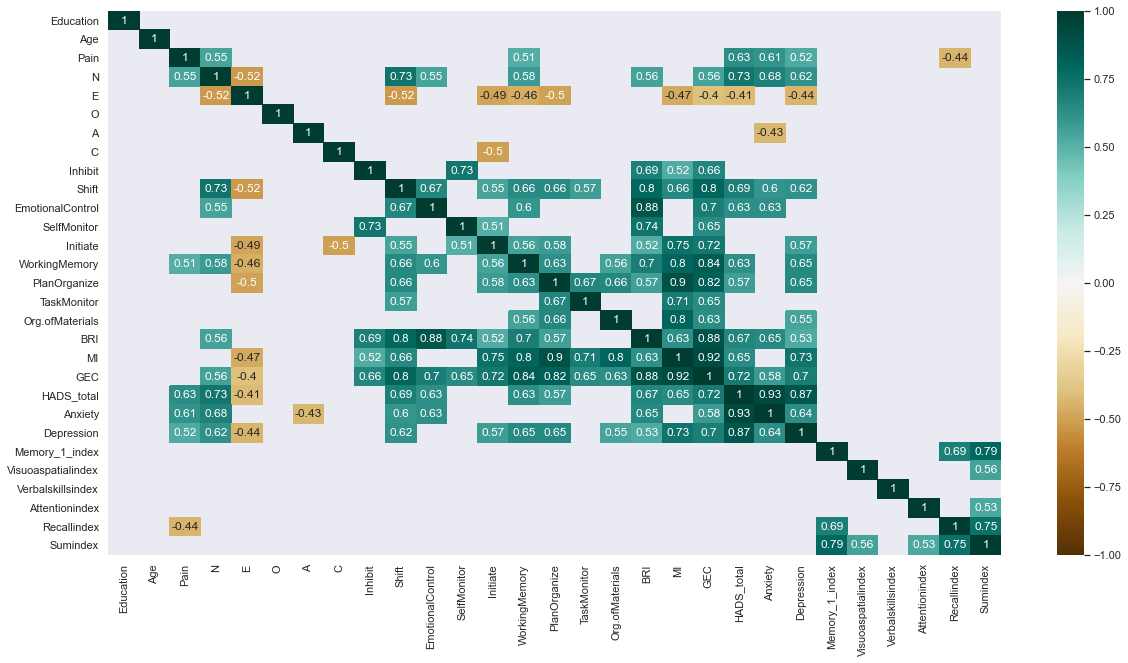

In [85]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c[(c >= 0.5) | (c <= -0.4)],cmap='BrBG', annot=True, vmax=1.0, vmin=-1.0, annot_kws={"size": 12})
c

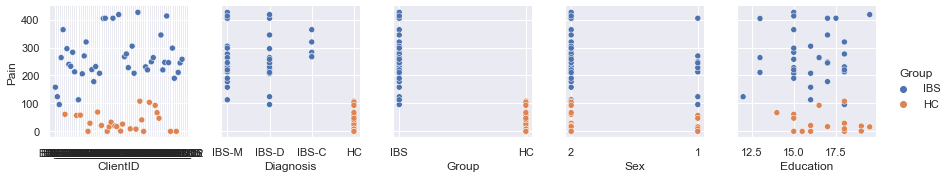

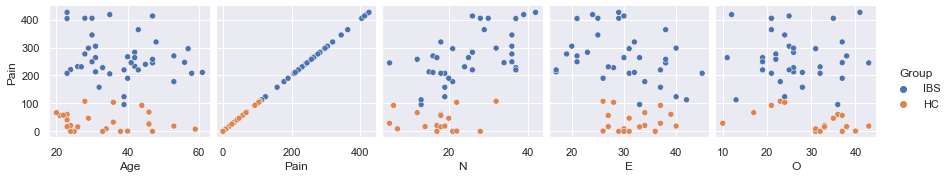

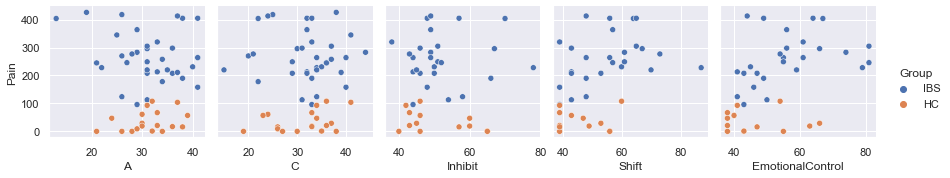

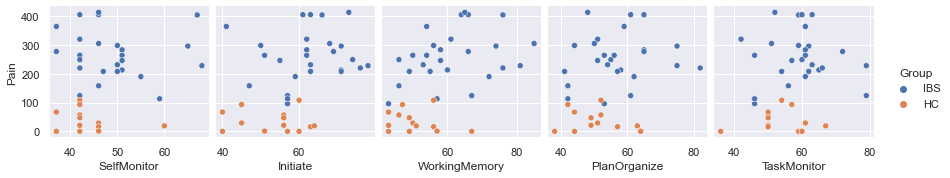

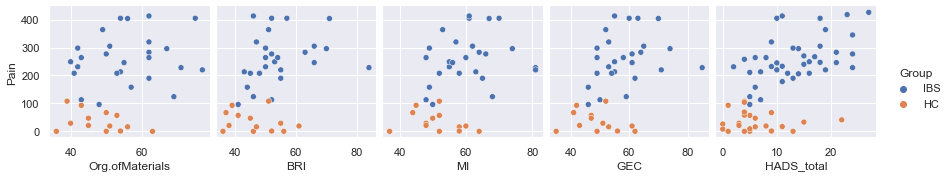

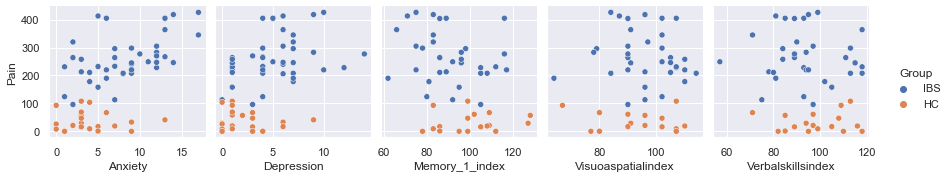

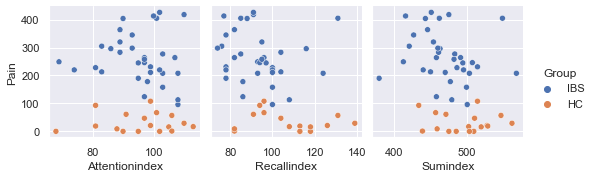

In [29]:
#plot  to see if they show some kind of pattern.
for i in range(0, len(df.columns), 5):
    sns.pairplot(data=df, hue='Group', diag_kind = None,
               x_vars=df.columns[i:i+5],
               y_vars=['Pain'])

In [30]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

# 2. Group analyses
## Independent t-tests RBANS IBS vs HC

In [31]:
# create a new df for analysing RBANS data for all groups
df_rbans = df[['ClientID','Diagnosis', 'Group', 'Memory_1_index', 'Visuoaspatialindex', 'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']]

In [33]:
df_rbans = df_rbans.dropna(subset=['Group','Memory_1_index'])
df_rbans.count()
df_rbans['Group'].value_counts()

IBS    43
HC     18
Name: Group, dtype: int64

In [34]:
df_rbans.groupby('Group').describe()

Memory_1_index                                                           \
               count        mean        std   min    25%    50%    75%    max   
Group                                                                           
HC              18.0  100.944444  14.264197  78.0  88.25  100.5  109.0  128.0   
IBS             43.0   90.162791  14.512606  62.0  80.50   89.0  101.0  117.0   

      Visuoaspatialindex                                                 \
                   count       mean        std   min   25%   50%    75%   
Group                                                                     
HC                  18.0  94.222222  13.022856  67.0  82.5  96.0  107.0   
IBS                 43.0  94.906977  12.057035  64.0  87.0  96.0  105.0   

             Verbalskillsindex                                          \
         max             count       mean        std   min   25%   50%   
Group                                                                    
HC     110.0              18.0  98.111111  12.879025  71.0  90.0  97.0   
IBS    114.0              43.0  96.488372  14.523170  57.0  87.0  95.0   

                     Attentionindex                                           \
          75%    max          count       mean        std   min    25%   50%   
Group                                                                          
HC     108.75  118.0           18.0  99.000000  17.081121  68.0  90.25  99.0   
IBS    111.00  118.0           43.0  94.744186  10.661665  69.0  88.50  97.0   

                     Recallindex                                            \
          75%    max       count        mean        std   min   25%    50%   
Group                                                                        
HC     105.75  150.0        18.0  108.055556  15.820583  82.0  96.0  110.5   
IBS    102.50  115.0        43.0   93.511628  13.591615  74.0  83.5   93.0   

                     Sumindex                                              \
          75%    max    count        mean        std    min    25%    50%   
Group                                                                       
HC     116.75  139.0     18.0  500.333333  39.021864  434.0  472.0  506.0   
IBS    100.00  131.0     43.0  469.813953  40.892575  380.0  448.0  463.0   

                     
         75%    max  
Group                
HC     525.0  567.0  
IBS    492.5  567.0

In [273]:
rbans = ['Memory_1_index', 'Visuoaspatialindex', 'Verbalskillsindex','Attentionindex','Recallindex', 'Sumindex']

In [274]:
groups = ['IBS', 'HC']
VARS = {}
for g in groups:
    VARS[g] = {}
    for r in rbans: 
        VARS[g][r] = df_rbans.query('Group == "{}"'.format(g))[r]

T-test for  Memory_1_index


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.659375,59,two-sided,0.010063,"[-18.89, -2.67]",0.746576,4.751,0.74406


T-test for  Visuoaspatialindex


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.197614,59,two-sided,0.844027,"[-6.25, 7.62]",0.055477,0.286,0.054341


T-test for  Verbalskillsindex


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.410853,59,two-sided,0.682669,"[-9.53, 6.28]",0.11534,0.301,0.068918


T-test for  Attentionindex


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.180224,59,two-sided,0.242648,"[-11.47, 2.96]",0.331329,0.497,0.213076


T-test for  Recallindex


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-3.630572,59,two-sided,0.000593,"[-22.56, -6.53]",1.019224,47.434,0.946399


T-test for  Sumindex


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.693418,59,two-sided,0.009194,"[-53.19, -7.85]",0.756133,5.098,0.754711


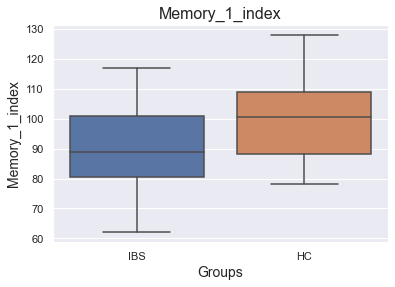

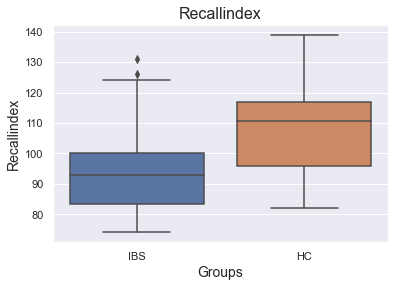

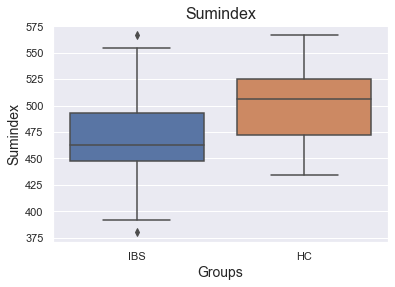

In [275]:
#calculating t-test stats. Output for p-values > .05
for r in rbans:
    res_rbans = pg.ttest(VARS['IBS'][r], VARS['HC'][r], correction=False)
    pval = res_rbans['p-val'].item()
    #if pval < 0.05:
    print("T-test for ", r)
    display(res_rbans)

    if pval < 0.05:
        #visualise data
        plt.figure()
        boxplot = sns.boxplot(x='Group', y=r, data=df_rbans)
        boxplot.axes.set_title(r, fontsize=16)
        boxplot.set_xlabel("Groups", fontsize=14)
        boxplot.set_ylabel(r, fontsize=14)

In [38]:
#calculating pairwise
for r in rbans:
    res_rbans = pg.pairwise_ttests(dv=r, between='Group', data=df, padjust='holm').round(2)
    display(r ,res_rbans)

'Memory_1_index'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,2.68,32.46,two-sided,0.01,4.943,0.74


'Visuoaspatialindex'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,-0.19,29.83,two-sided,0.85,0.285,-0.05


'Verbalskillsindex'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,0.43,35.81,two-sided,0.67,0.303,0.11


'Attentionindex'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,0.98,22.75,two-sided,0.34,0.417,0.33


'Recallindex'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,3.41,28.04,two-sided,0.0,26.706,1.01


'Sumindex'

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Group,HC,IBS,False,True,2.75,33.37,two-sided,0.01,5.7,0.75


## Check whether the proportion of men and women in each group are similar
I would be using Fisher’s Exact test is used to test the hypothesis that the proportion of men and women in each group is the same. 


In [86]:
df_sex =  df[['Sex', 'Group']]
df_sex.head()

#(1 = M, 2 = F)

,Sex,Group
0,2,IBS
1,1,IBS
2,1,IBS
4,2,IBS
5,2,IBS


In [41]:
sex = df_sex.groupby(['Group', 'Sex']).size().to_dict()

In [42]:
sex.keys()

dict_keys([('HC', '1'), ('HC', '2'), ('IBS', '1'), ('IBS', '2')])

In [43]:
from scipy.stats import fisher_exact


oddsratio, pvalue = fisher_exact([
    [sex[('HC', '1')], sex[('HC', '2')]], 
    [sex[('IBS', '1')], sex[('IBS', '2')]]
    ])
print('Fisher exact test p-value: {:.4f}'.format(pvalue))



Fisher exact test p-value: 0.1623


As expected, the exact p-value is not statistically significant, showing that the proportions of men and women between groups are not different. Since there is no difference in the proportion between men and women between HC and IBS group, we would not need to include Sex in the regression model.

## T-test - Age in IBS patients vs Healthy Controls

In [44]:
df_age =  df[['Age', 'Group']]
df_age = df_age.dropna(subset=['Group','Age'])
df_age['Group'].value_counts()

IBS    50
HC     31
Name: Group, dtype: int64

In [45]:
df_age.groupby('Group').describe()

Age                                                    
      count       mean        std   min   25%   50%   75%   max
Group                                                          
HC     31.0  33.354839  11.010747  20.0  23.5  31.0  42.0  59.0
IBS    50.0  38.760000  10.710590  20.0  30.0  39.0  47.0  61.0

In [46]:
for g in groups:
    VARS[g] = {}
    VARS[g]['Age'] = df_age.query('Group == "{}"'.format(g))['Age']

In [47]:
#checking the normality of data
print(stats.shapiro(VARS['IBS']['Age']))
print(stats.shapiro(VARS['HC']['Age']))

ShapiroResult(statistic=0.9679672718048096, pvalue=0.19108663499355316)
ShapiroResult(statistic=0.9045907258987427, pvalue=0.009402990341186523)


The tuple above contains the test statistics and the p-value. Here, the null hypothesis is that the data follows a normal distribution.
For Age, we can infer that the data from both groups is normally distributed.

In [48]:
# Checking the Homogeneity of Variances Assumption
print(stats.levene(VARS['IBS']['Age'], VARS['HC']['Age']))

LeveneResult(statistic=0.08875626305950994, pvalue=0.7665464063377788)


the p-value suggests that the data follows the assumption of equal variances

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.184147,79,two-sided,0.031917,"[0.48, 10.33]",0.499297,1.809,0.578333


Text(0, 0.5, 'Age score')

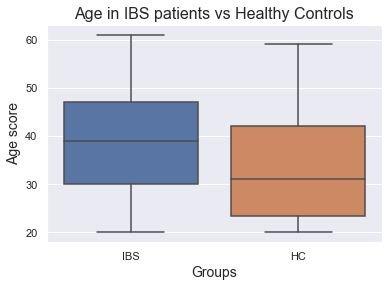

In [49]:
# T-test Age in IBS vs Healthy Controls 
res_Age = pg.ttest(VARS['IBS']['Age'], VARS['HC']['Age'], correction=False)
display(res_Age)
#visualise data
boxplot = sns.boxplot(x='Group', y='Age', data=df)
boxplot.axes.set_title("Age in IBS patients vs Healthy Controls", fontsize=16)
boxplot.set_xlabel("Groups", fontsize=14)
boxplot.set_ylabel("Age score", fontsize=14)

## T-Test HADS scores IBS vs HC

In [50]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

In [89]:
df_hads =  df[['HADS_total','Anxiety', 'Depression', 'Group']]
df_hads = df_hads.dropna(subset=['Group','HADS_total'])

df_hads['Group'].value_counts()

IBS    42
HC     25
Name: Group, dtype: int64

In [90]:
df_hads.groupby('Group').describe()

HADS_total                                                  Anxiety  \
           count       mean       std  min  25%   50%   75%   max   count   
Group                                                                       
HC          25.0   5.880000  5.101634  0.0  3.0   4.0   8.0  22.0    25.0   
IBS         42.0  13.452381  6.371439  2.0  9.0  13.0  18.0  27.0    42.0   

                                                     Depression            \
           mean       std  min  25%  50%   75%   max      count      mean   
Group                                                                       
HC     3.840000  3.118226  0.0  2.0  3.0   5.0  13.0       25.0  2.040000   
IBS    8.285714  4.307032  1.0  5.0  8.5  12.0  17.0       42.0  5.166667   

                                           
            std  min  25%  50%  75%   max  
Group                                      
HC     2.318045  0.0  0.0  1.0  3.0   9.0  
IBS    3.122824  0.0  4.0  5.0  7.0  14.0

In [100]:
hads = ['HADS_total','Anxiety', 'Depression']
VARS = {}
for g in groups:
    VARS[g] = {}
    for h in hads:
        VARS[g][h] = df_hads.query('Group == "{}"'.format(g))[h]

In [ ]:
res

T-test for  HADS_total


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,5.051487,65,two-sided,0.000004,"[4.58, 10.57]",1.276033,3995.694,0.998718


T-test for  Anxiety


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.500671,65,two-sided,0.000029,"[2.47, 6.42]",1.136894,658.786,0.993306


T-test for  Depression


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.339628,65,two-sided,0.000051,"[1.69, 4.57]",1.096214,398.13,0.989686


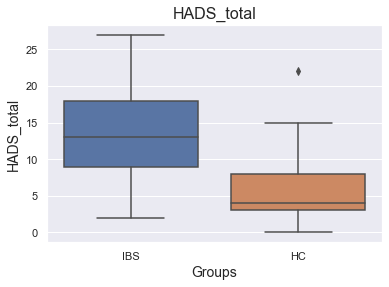

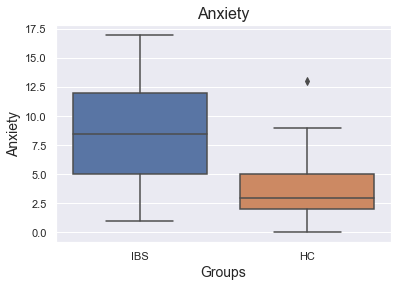

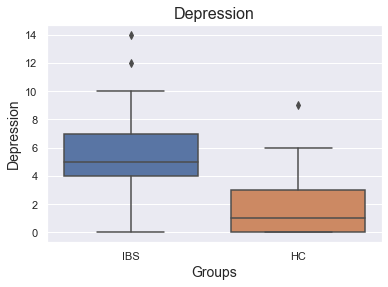

In [102]:
#calculating t-test stats. Output for p-values > .05
for h in hads:
    res_hads = pg.ttest(VARS['IBS'][h], VARS['HC'][h], correction=False)
    pval = res_hads['p-val'].item()
    if pval < 0.05:
        print("T-test for ", h)
        display(res_hads)
    
        #visualise data
        plt.figure()
        boxplot = sns.boxplot(x='Group', y=h, data=df_hads)
        boxplot.axes.set_title(h, fontsize=16)
        boxplot.set_xlabel("Groups", fontsize=14)
        boxplot.set_ylabel(h, fontsize=14)

## T-Test pain scores IBS vs HC

In [95]:
df_pain = df [['Pain', 'Group']]
df_pain = df_pain.dropna(subset=['Group','Pain'])
df_pain['Group'].value_counts()

IBS    42
HC     25
Name: Group, dtype: int64

In [96]:
df_pain.groupby('Group').describe()

Pain                                                          
      count        mean        std   min     25%    50%    75%    max
Group                                                                
HC     25.0   35.360000  33.815529   0.0    8.00   26.0   58.0  108.0
IBS    42.0  261.880952  82.217499  96.0  214.75  246.5  297.5  426.0

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,13.099748,65,two-sided,6.685599e-20,"[191.99, 261.06]",3.309068,4.213e+16,1.0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,13.099748,65,two-sided,6.685599e-20,"[191.99, 261.06]",3.309068,4.213e+16,1.0


Text(0, 0.5, 'Pain score')

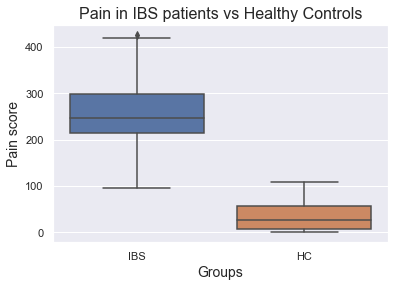

In [98]:
for g in groups:
    VARS[g] = {}
    VARS[g]['Pain'] = df_pain.query('Group == "{}"'.format(g))['Pain']
res_pain = pg.ttest(VARS['IBS']['Pain'], VARS['HC']['Pain'], correction=False)
display(res_pain)
#visualise data
boxplot = sns.boxplot(x='Group', y='Pain', data=df)
boxplot.axes.set_title("Pain in IBS patients vs Healthy Controls", fontsize=16)
boxplot.set_xlabel("Groups", fontsize=14)
boxplot.set_ylabel("Pain score", fontsize=14)

## T-test BRIEF-A

In [103]:
df_brief_pain = df

df_brief_pain.count()

ClientID              87
Diagnosis             87
Group                 87
Sex                   65
Education             60
Age                   81
Pain                  67
N                     65
E                     65
O                     65
A                     65
C                     65
Inhibit               43
Shift                 43
EmotionalControl      43
SelfMonitor           43
Initiate              43
WorkingMemory         43
PlanOrganize          43
TaskMonitor           43
Org.ofMaterials       43
BRI                   43
MI                    43
GEC                   43
HADS_total            67
Anxiety               67
Depression            67
Memory_1_index        61
Visuoaspatialindex    61
Verbalskillsindex     61
Attentionindex        61
Recallindex           61
Sumindex              61
dtype: int64

In [104]:
df_brief_pain = df_brief_pain.dropna(subset=['Diagnosis', 'Pain', 'Group', 'Inhibit', 'Shift', 'EmotionalControl','SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize', 'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC' ])
df_brief_pain.count()

ClientID              39
Diagnosis             39
Group                 39
Sex                   39
Education             38
Age                   38
Pain                  39
N                     39
E                     39
O                     39
A                     39
C                     39
Inhibit               39
Shift                 39
EmotionalControl      39
SelfMonitor           39
Initiate              39
WorkingMemory         39
PlanOrganize          39
TaskMonitor           39
Org.ofMaterials       39
BRI                   39
MI                    39
GEC                   39
HADS_total            39
Anxiety               39
Depression            39
Memory_1_index        39
Visuoaspatialindex    39
Verbalskillsindex     39
Attentionindex        39
Recallindex           39
Sumindex              39
dtype: int64

In [105]:
brief = ['Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC']

In [106]:
df_brief_pain['Group'].value_counts()

IBS    26
HC     13
Name: Group, dtype: int64

In [107]:
groups = ['IBS', 'HC']
VARS = {}
for g in groups:
    VARS[g] = {}
    for b in brief:
        VARS[g][b] = df_brief_pain.query('Group == "{}"'.format(g))[b]



In [108]:
df_brief_pain.groupby('Group').describe()

Education                                                          Age  \
          count       mean       std   min     25%    50%    75%   max count   
Group                                                                          
HC         12.0  17.041667  1.776850  14.0  15.875  17.25  18.25  19.5  13.0   
IBS        26.0  15.846154  1.647842  12.0  15.000  16.00  17.00  18.0  25.0   

                                                           Pain              \
            mean        std   min   25%   50%   75%   max count        mean   
Group                                                                         
HC     31.769231  10.599952  20.0  24.0  28.0  40.0  53.0  13.0   35.230769   
IBS    36.600000   9.526279  23.0  30.0  33.0  42.0  58.0  26.0  260.846154   

                                                         N             \
             std   min     25%    50%     75%    max count       mean   
Group                                                                   
HC     36.542564   0.0    1.00   21.0   57.00  108.0  13.0  18.923077   
IBS    89.422902  96.0  209.25  256.5  303.25  413.0  26.0  25.576923   

                                                  E                       \
            std   min   25%   50%   75%   max count       mean       std   
Group                                                                      
HC     7.983958   5.0  17.0  19.0  22.0  32.0  13.0  31.923077  4.424582   
IBS    8.169079  13.0  19.0  25.5  33.5  37.0  26.0  29.730769  7.982770   

                                        O                                   \
        min   25%   50%   75%   max count       mean       std   min   25%   
Group                                                                        
HC     26.0  29.0  31.0  34.0  40.0  13.0  29.692308  9.419701  10.0  23.0   
IBS    17.0  23.5  30.0  36.0  45.0  26.0  25.769231  7.229427  11.0  21.0   

                             A                                                \
        50%    75%   max count       mean       std   min   25%   50%    75%   
Group                                                                          
HC     32.0  35.00  43.0  13.0  30.538462  5.043401  21.0  28.0  31.0  33.00   
IBS    25.5  31.75  37.0  26.0  32.615385  6.597435  13.0  29.0  32.0  37.75   

                C                                                     Inhibit  \
        max count       mean       std   min    25%   50%   75%   max   count   
Group                                                                           
HC     39.0  13.0  31.615385  5.923660  19.0  27.00  34.0  36.0  38.0    13.0   
IBS    41.0  26.0  31.769231  6.114296  15.0  30.25  32.5  34.0  44.0    26.0   

                                                         Shift             \
            mean       std   min   25%   50%   75%   max count       mean   
Group                                                                       
HC     50.615385  9.260476  40.0  43.0  46.0  60.0  65.0  13.0  47.307692   
IBS    51.769231  9.279257  38.0  46.0  49.0  53.5  78.0  26.0  55.115385   

                                                 EmotionalControl             \
             std   min    25%   50%    75%   max            count       mean   
Group                                                                          
HC      8.097166  39.0  39.00  47.0  56.00  60.0             13.0  46.461538   
IBS    12.080818  39.0  44.25  56.0  63.25  87.0             26.0  56.423077   

                                                 SelfMonitor             \
             std   min    25%   50%    75%   max       count       mean   
Group                                                                     
HC      9.862516  38.0  38.00  43.0  54.00  66.0        13.0  43.846154   
IBS    12.355317  41.0  46.25  55.0  63.25  81.0        26.0  48.730769   

                                              Initiate                       \
            std   min 

T-test for  Shift


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.099337,37,two-sided,0.042668,"[0.27, 15.34]",0.713109,1.722,0.53379


T-test for  EmotionalControl


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.526869,37,two-sided,0.015914,"[1.97, 17.95]",0.858335,3.515,0.691779


T-test for  Initiate


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.055466,37,two-sided,0.004154,"[3.12, 15.42]",1.03789,9.812,0.845022


T-test for  WorkingMemory


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.146095,37,two-sided,0.00326,"[3.81, 17.58]",1.068675,11.87,0.865095


T-test for  Org.ofMaterials


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.262357,37,two-sided,0.029637,"[0.79, 14.36]",0.768485,2.231,0.596175


T-test for  BRI


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.411173,37,two-sided,0.020982,"[1.25, 14.37]",0.819035,2.867,0.651102


T-test for  MI


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.058892,37,two-sided,0.004116,"[3.08, 15.15]",1.039054,9.882,0.845815


T-test for  GEC


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.076956,37,two-sided,0.003923,"[3.17, 15.37]",1.04519,10.261,0.849951


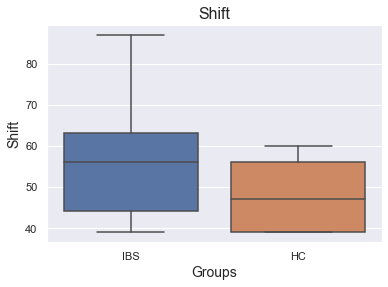

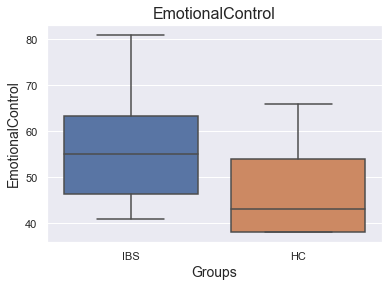

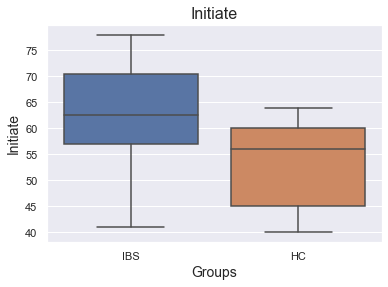

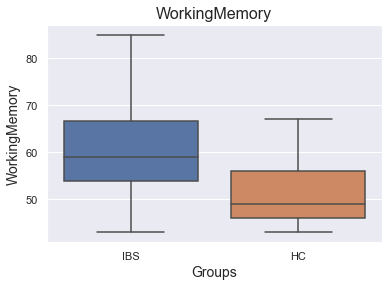

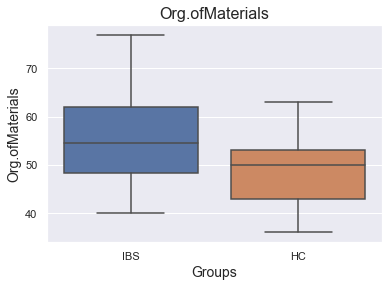

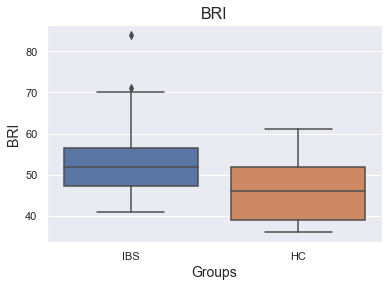

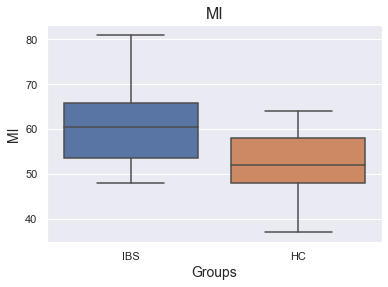

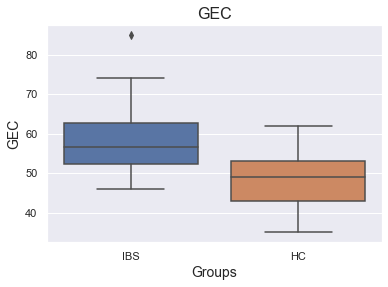

In [109]:
for b in brief:
    res_brief = pg.ttest(VARS['IBS'][b], VARS['HC'][b], correction=False)
    pval = res_brief['p-val'].item()
    if pval < 0.05:
        print("T-test for ", b)
        display(res_brief)
    
        #visualise data
        plt.figure()
        boxplot = sns.boxplot(x='Group', y=b, data=df_brief_pain)
        boxplot.axes.set_title(b, fontsize=16)
        boxplot.set_xlabel("Groups", fontsize=14)
        boxplot.set_ylabel(b, fontsize=14)

## Independent sample t-test -  NEOPI in  IBS vs HC

In [110]:
#making a temp df dropping the Pain and N rows with no data
df_NEOPI_Pain = df
df_NEOPI_Pain = df_NEOPI_Pain.dropna(subset=['Pain','N'])

In [112]:
df_NEOPI_Pain['Group'].unique()


array(['IBS', 'HC'], dtype=object)

In [113]:
df_NEOPI_Pain['Group'].value_counts()

IBS    35
HC     18
Name: Group, dtype: int64

In [114]:
#deal with missing data

df_NEOPI_Pain = df_NEOPI_Pain[df_NEOPI_Pain.Group.notna()]

In [ ]:
# Comparing two means to see if they are statistically different from each other.
# Check if the differences are statistically significant.
# Null hypotheses: Two group means are equal
# Assumption 1: Are the two samples independent?
# Assumption 2: Are the data from each of the 2 groups following a normal distribution?
# Assumption 3: Do the two samples have the same variances (Homogeneity of Variance)?

In [115]:
len(df_NEOPI_Pain[df_NEOPI_Pain["Pain"].isna()])

0

In [116]:
dimensions = ['N','E','O','A','C']
#preparing group data
groups = ['IBS', 'HC']
NEOPI = {}
'''
    NEOPI is struct in format:
        {'IBS' or 'HC': {'Short name for Dimension': 'PD series from df'}}
'''
for g in groups:
    NEOPI[g] = {}
    for d in dimensions:
        df_NEOPI_Pain = df_NEOPI_Pain[df_NEOPI_Pain[d].notna()]
        NEOPI[g][d] = df_NEOPI_Pain.query('Group == "{}"'.format(g))[d]  

In [117]:
#Descriptive Statistics
pd.set_option('display.max_columns', None)
df_NEOPI_Pain.groupby('Group').describe()

Education                                                         Age  \
          count       mean       std   min     25%    50%   75%   max count   
Group                                                                         
HC         16.0  16.843750  1.700184  14.0  15.375  16.75  18.0  19.5  18.0   
IBS        34.0  15.985294  1.729798  12.0  15.000  16.00  17.0  19.5  34.0   

                                                           Pain              \
            mean        std   min   25%   50%   75%   max count        mean   
Group                                                                         
HC     31.500000   9.587062  20.0  24.0  28.5  37.5  53.0  18.0   36.055556   
IBS    38.323529  10.536288  23.0  30.0  39.0  46.0  61.0  35.0  267.228571   

                                                       N                       \
             std   min    25%    50%    75%    max count       mean       std   
Group                                                                           
HC     37.311837   0.0    3.0   20.0   60.0  108.0  18.0  18.000000  7.396342   
IBS    88.931595  96.0  212.0  258.0  312.5  426.0  35.0  25.085714  9.441371   

                                         E                                    \
       min    25%   50%    75%   max count       mean       std   min    25%   
Group                                                                          
HC     5.0  14.75  18.0  21.75  32.0  18.0  31.944444  4.504537  26.0  28.25   
IBS    5.0  18.00  25.0  35.00  42.0  35.0  30.028571  7.543933  17.0  24.50   

                            O                                                 \
        50%   75%   max count       mean       std   min    25%   50%    75%   
Group                                                                          
HC     31.0  35.5  40.0  18.0  30.666667  8.554325  10.0  25.75  32.5  36.75   
IBS    30.0  37.0  45.0  35.0  26.457143  8.023285  11.0  21.00  25.0  32.00   

                A                                                          C  \
        max count       mean       std   min    25%   50%    75%   max count   
Group                                                                          
HC     43.0  18.0  31.277778  4.737902  21.0  29.25  31.5  33.75  39.0  18.0   
IBS    43.0  35.0  31.457143  6.714089  13.0  27.50  31.0  36.50  41.0  35.0   

                                                           Inhibit             \
            mean       std   min    25%   50%    75%   max   count       mean   
Group                                                                           
HC     31.388889  5.952151  19.0  26.25  33.0  35.75  41.0    13.0  50.615385   
IBS    31.942857  6.507655  15.0  29.50  33.0  36.00  44.0    26.0  51.769231   

                                              Shift                        \
            std   min   25%   50%   75%   max count       mean        std   
Group                                                                       
HC     9.260476  40.0  43.0  46.0  60.0  65.0  13.0  47.307692   8.097166   
IBS    9.279257  38.0  46.0  49.0  53.5  78.0  26.0  55.115385  12.080818   

                                      EmotionalControl                        \
        min    25%   50%    75%   max            count       mean        std   
Group                                                                          
HC     39.0  39.00  47.0  56.00  60.0             13.0  46.461538   9.862516   
IBS    39.0  44.25  56.0  63.25  87.0             26.0  56.423077  12.355317   

                                      SelfMonitor                             \
        min    25%   50%    75%   max       count       mean       std   min   
Group                                                                          
HC     38.0  38.00  43.0  54.00  66.0        13.0  43.846154  5.727800  37.0   
IBS    41.0  46.25  55.0  63.25  81.0        26.0  48.730769  8.402655  37.0   

           

array([[<AxesSubplot:title={'center':'N'}>,
        <AxesSubplot:title={'center':'E'}>],
       [<AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'C'}>, <AxesSubplot:>]], dtype=object)

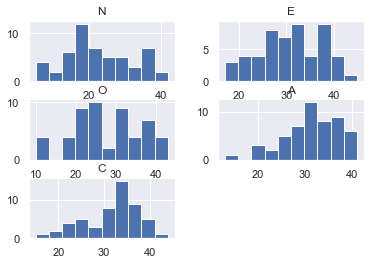

In [118]:
df_NEOPI_Pain[dimensions].hist()

In [119]:
#checking the normality of data
for value in NEOPI['IBS'].values():
    print(stats.shapiro(value))

ShapiroResult(statistic=0.954628050327301, pvalue=0.15713398158550262)
ShapiroResult(statistic=0.9706928133964539, pvalue=0.4625663757324219)
ShapiroResult(statistic=0.9637784361839294, pvalue=0.2959328889846802)
ShapiroResult(statistic=0.9576885104179382, pvalue=0.19474831223487854)
ShapiroResult(statistic=0.9491422176361084, pvalue=0.10664575546979904)


In [120]:
for value in NEOPI['HC'].values():
    print(stats.shapiro(value))

ShapiroResult(statistic=0.953597903251648, pvalue=0.48420652747154236)
ShapiroResult(statistic=0.9393361806869507, pvalue=0.28229597210884094)
ShapiroResult(statistic=0.9234523773193359, pvalue=0.14881251752376556)
ShapiroResult(statistic=0.9757297039031982, pvalue=0.8957356810569763)
ShapiroResult(statistic=0.9485582113265991, pvalue=0.40285012125968933)


The tuple above contains the test statistics and the p-value. Here, the null hypothesis is that the data follows a normal distribution. Thus, we can infer that the data from both groups is normally distributed.

In [121]:
# Checking the Homogeneity of Variances Assumption
for d in dimensions:
    print(stats.levene(NEOPI['IBS'][d], NEOPI['HC'][d]))

LeveneResult(statistic=3.6914678155341125, pvalue=0.060288818030752984)
LeveneResult(statistic=5.307753850256685, pvalue=0.025340181214039584)
LeveneResult(statistic=0.0001962817258551814, pvalue=0.988876620572982)
LeveneResult(statistic=2.0643453233992357, pvalue=0.1568863826739628)
LeveneResult(statistic=0.006670603450077346, pvalue=0.9352258375787341)


the p-value suggests that the data follows the assumption of equal variances for all but Extraversion (pvalue=0.03). For extraversion, I would be performing Welch’s t-test instead of Student’s t-test.

In [122]:
#set the correction to False as the LeveneResult shows that data do not violate the homogeneity assumption

for d in dimensions:
    res_neopi = pg.ttest(NEOPI['IBS'][d], NEOPI['HC'][d], correction=False)
    pval = res_neopi['p-val'].item()
   # if pval < 0.05:
    print("T-test for ", d)
    display(res_neopi)
    
        #visualise data
        #plt.figure()
       # boxplot = sns.boxplot(x='Group', y=d, data=df_NEOPI_Pain)
       # boxplot.axes.set_title(d, fontsize=16)
       # boxplot.set_xlabel("Groups", fontsize=14)
        #boxplot.set_ylabel(d, fontsize=14)

T-test for  N


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.772125,51,two-sided,0.007756,"[1.95, 12.22]",0.804045,5.894,0.776261


T-test for  E


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.987927,51,two-sided,0.327853,"[-5.81, 1.98]",0.286545,0.429,0.162649


T-test for  O


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.769023,51,two-sided,0.08287,"[-8.99, 0.57]",0.513099,1.015,0.411387


T-test for  A


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.100937,51,two-sided,0.919996,"[-3.39, 3.75]",0.029276,0.29,0.051125


T-test for  C


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.301826,51,two-sided,0.764012,"[-3.13, 4.24]",0.087544,0.299,0.060109


T-test Neuroticism scores in IBS vs Healthy Controls explained:

P-value is 0.007756, which is less than the significance level alpha (e.g., 0.05). This means that we can conclude that the average Neuroticism score in the IBS group is statistically different from N-score in healthy controls. Cohen-D is 0.804045, meaning that there is a large effect size (>0.8).

In [123]:
# Welch's t-test Extraversion scores in IBS vs Healthy Controls
res_E = stats.ttest_ind(NEOPI['IBS']['E'], NEOPI['HC']['E'], equal_var = False)
display(res_E)

Ttest_indResult(statistic=-1.1546232053486396, pvalue=0.2537658182227966)

Welch's t-test Extraversion scores in IBS vs Healthy Controls explained:

P-value is 0.253765, which is more than the significance level alpha (e.g., 0.05). E score is not statistically different in IBS from E score in healthy controls.

## ANOVA - NEOPI vs IBS Rome III criteria and Healthy controls
The Analysis of Variance  (ANOVA) is a statistical method used to test whether there are significant differences between the means of two or more groups. The following groups are being analysed 'IBS-M', 'IBS-D', 'IBS-C', 'HC'

One-way ANOVA Don't forget to check for assumptions:
1. the groups have to be independent of each other.
2. the data needs to be normally distributed (within each group). Normality assumption can be tested using the  Shapiro-Wilks test or by examining the distribution.
3. There have to be equal variances between all groups. Homogeneity of variances can be tested with Bartlett’s and Levene’s test in Python

In [124]:
df.count()

ClientID              87
Diagnosis             87
Group                 87
Sex                   65
Education             60
Age                   81
Pain                  67
N                     65
E                     65
O                     65
A                     65
C                     65
Inhibit               43
Shift                 43
EmotionalControl      43
SelfMonitor           43
Initiate              43
WorkingMemory         43
PlanOrganize          43
TaskMonitor           43
Org.ofMaterials       43
BRI                   43
MI                    43
GEC                   43
HADS_total            67
Anxiety               67
Depression            67
Memory_1_index        61
Visuoaspatialindex    61
Verbalskillsindex     61
Attentionindex        61
Recallindex           61
Sumindex              61
dtype: int64

In [280]:
df['Diagnosis'].unique()

array(['IBS-M', 'IBS-D', 'IBS-C', 'HC'], dtype=object)

In [281]:
#making a temp df dropping the Pain, Diagnosis, and N rows with no data
df_NEOPI_Pain_Rome = df
df_NEOPI_Pain_Rome = df_NEOPI_Pain_Rome.dropna(subset=['Diagnosis','N', 'Pain'])
df_NEOPI_Pain_Rome.count()

ClientID              53
Diagnosis             53
Group                 53
Sex                   53
Education             50
Age                   52
Pain                  53
N                     53
E                     53
O                     53
A                     53
C                     53
Inhibit               39
Shift                 39
EmotionalControl      39
SelfMonitor           39
Initiate              39
WorkingMemory         39
PlanOrganize          39
TaskMonitor           39
Org.ofMaterials       39
BRI                   39
MI                    39
GEC                   39
HADS_total            53
Anxiety               53
Depression            53
Memory_1_index        51
Visuoaspatialindex    51
Verbalskillsindex     51
Attentionindex        51
Recallindex           51
Sumindex              51
dtype: int64

In [127]:
#Descriptive Statistics
df_NEOPI_Pain_Rome.groupby('Diagnosis').describe()

Education                                                        \
              count       mean       std   min     25%    50%   75%   max   
Diagnosis                                                                   
HC             16.0  16.843750  1.700184  14.0  15.375  16.75  18.0  19.5   
IBS-C           3.0  16.000000  1.732051  15.0  15.000  15.00  16.5  18.0   
IBS-D          14.0  15.892857  2.167758  12.0  15.000  16.50  17.0  19.5   
IBS-M          17.0  16.058824  1.401811  13.0  15.000  16.00  17.0  18.0   

            Age                                                        Pain  \
          count       mean        std   min    25%   50%    75%   max count   
Diagnosis                                                                     
HC         18.0  31.500000   9.587062  20.0  24.00  28.5  37.50  53.0  18.0   
IBS-C       4.0  46.500000   5.066228  42.0  42.75  45.5  49.25  53.0   4.0   
IBS-D      14.0  39.571429  12.451224  23.0  30.00  37.0  47.00  61.0  14.0   
IBS-M      16.0  35.187500   8.658089  23.0  28.75  32.5  41.25  53.0  17.0   

                                                                         N  \
                 mean        std    min     25%    50%    75%    max count   
Diagnosis                                                                    
HC          36.055556  37.311837    0.0    3.00   20.0   60.0  108.0  18.0   
IBS-C      309.250000  42.200908  270.0  279.75  301.5  331.0  364.0   4.0   
IBS-D      254.142857  91.331061   96.0  208.75  247.0  288.0  418.0  14.0   
IBS-M      268.117647  95.408911  113.0  213.00  246.0  305.0  426.0  17.0   

                                                                   E  \
                mean       std   min    25%   50%    75%   max count   
Diagnosis                                                              
HC         18.000000  7.396342   5.0  14.75  18.0  21.75  32.0  18.0   
IBS-C      22.250000  6.238322  16.0  17.50  22.0  26.75  29.0   4.0   
IBS-D      22.214286  9.885332   5.0  16.50  20.0  27.25  39.0  14.0   
IBS-M      28.117647  9.150699  13.0  20.00  30.0  36.00  42.0  17.0   

                                                                   O  \
                mean       std   min    25%   50%    75%   max count   
Diagnosis                                                              
HC         31.944444  4.504537  26.0  28.25  31.0  35.50  40.0  18.0   
IBS-C      28.500000  7.937254  21.0  22.50  27.5  33.50  38.0   4.0   
IBS-D      31.714286  6.672891  21.0  27.50  31.0  36.75  45.0  14.0   
IBS-M      29.000000  8.291562  17.0  21.00  29.0  37.00  42.0  17.0   

                                                                   A  \
                mean       std   min    25%   50%    75%   max count   
Diagnosis                                                              
HC         30.666667  8.554325  10.0  25.75  32.5  36.75  43.0  18.0   
IBS-C      30.500000  8.346656  21.0  24.75  31.5  37.25  38.0   4.0   
IBS-D      26.000000  8.124038  12.0  21.00  24.0  31.75  43.0  14.0   
IBS-M      25.882353  8.092298  11.0  22.00  25.0  28.00  41.0  17.0   

                                                                   C  \
                mean       std   min    25%   50%    75%   max count   
Diagnosis                                                              
HC         31.277778  4.737902  21.0  29.25  31.5  33.75  39.0  18.0   
IBS-C      29.250000  2.872281  26.0  28.25  29.0  30.00  33.0   4.0   
IBS-D      31.857143  6.074627  21.0  26.75  31.0  36.75  41.0  14.0   
IBS-M      31.647059  7.928912  13.0  28.00  33.0  37.00  41.0  17.0   

                                                               Inhibit  \
                mean       std   min    25%   50%    75%   max   count   
Diagnosis                                                                
HC         31.388889  5.952151  19.0  26.25  33.0  35.75  41.0    13.0   
IBS-C      32.250000  9.810708  20.0  29.00  32.5  35

In [128]:
df_NEOPI_Pain_Rome['Diagnosis'].value_counts()

HC       18
IBS-M    17
IBS-D    14
IBS-C     4
Name: Diagnosis, dtype: int64

In [282]:
# preparing group data
groups_rome = ['IBS-C','IBS-D','IBS-M','HC']
NEOPI_rome = {}
'''
    NEOPI_rome is struct in format:
        {'IBS-C' or 'IBS-D' or'IBS-M' or 'HC': {'Short name for Dimension': 'PD series from df'}}
'''
for g in groups_rome:
    NEOPI_rome[g] = {}
    for d in dimensions:
        #print(d)
        NEOPI_rome[g][d] =  df_NEOPI_Pain_Rome.query('Diagnosis == "{}"'.format(g))[d]

In [130]:
#checking the normality of data (NEOAC sequence)
for g in groups_rome:
    for value in NEOPI_rome[g].values():
        print("Shapiro ", g, stats.shapiro(value))

Shapiro  IBS-C ShapiroResult(statistic=0.902550995349884, pvalue=0.4438404440879822)
Shapiro  IBS-C ShapiroResult(statistic=0.9191857576370239, pvalue=0.532392144203186)
Shapiro  IBS-C ShapiroResult(statistic=0.8737148642539978, pvalue=0.31248676776885986)
Shapiro  IBS-C ShapiroResult(statistic=0.9351223707199097, pvalue=0.6248208284378052)
Shapiro  IBS-C ShapiroResult(statistic=0.9613099098205566, pvalue=0.7871500253677368)
Shapiro  IBS-D ShapiroResult(statistic=0.9594531655311584, pvalue=0.7140761017799377)
Shapiro  IBS-D ShapiroResult(statistic=0.9728744029998779, pvalue=0.9125642776489258)
Shapiro  IBS-D ShapiroResult(statistic=0.9650125503540039, pvalue=0.8039056062698364)
Shapiro  IBS-D ShapiroResult(statistic=0.9634817242622375, pvalue=0.7797497510910034)
Shapiro  IBS-D ShapiroResult(statistic=0.9774401783943176, pvalue=0.9572443962097168)
Shapiro  IBS-M ShapiroResult(statistic=0.9228419661521912, pvalue=0.16494649648666382)
Shapiro  IBS-M ShapiroResult(statistic=0.9406955838203

The tuples above contains the test statistics and the p-value. Here, the null hypothesis is that the data follows a normal distribution. Thus, we can infer that the data from both groups is normally distributed.

In [131]:
# Checking the Homogeneity of Variances Assumption

print(stats.levene(NEOPI_rome['IBS-C']['N'], NEOPI_rome['IBS-M']['N'], NEOPI_rome['IBS-D']['N'], NEOPI_rome['HC']['N']))
print(stats.levene(NEOPI_rome['IBS-C']['E'], NEOPI_rome['IBS-M']['E'], NEOPI_rome['IBS-D']['E'], NEOPI_rome['HC']['E']))
print(stats.levene(NEOPI_rome['IBS-C']['O'], NEOPI_rome['IBS-M']['O'], NEOPI_rome['IBS-D']['O'], NEOPI_rome['HC']['O']))
print(stats.levene(NEOPI_rome['IBS-C']['A'], NEOPI_rome['IBS-M']['A'], NEOPI_rome['IBS-D']['A'], NEOPI_rome['HC']['A']))
print(stats.levene(NEOPI_rome['IBS-C']['C'], NEOPI_rome['IBS-M']['C'], NEOPI_rome['IBS-D']['C'], NEOPI_rome['HC']['C']))

LeveneResult(statistic=0.9888470507304913, pvalue=0.4058364605604907)
LeveneResult(statistic=2.4433590759651582, pvalue=0.0751770988868156)
LeveneResult(statistic=0.07196092793493662, pvalue=0.9747013715108794)
LeveneResult(statistic=1.7569472087716966, pvalue=0.167714127704845)
LeveneResult(statistic=0.47660872078390154, pvalue=0.7000150570511336)


The p-values suggests that the data follows the assumption of equal variances 

In [132]:
# One-Way Anova Neuroticism scores between groups 
aov = pg.anova(dv='N', between='Diagnosis', data=df_NEOPI_Pain_Rome, detailed=True)
print(aov)

      Source           SS  DF          MS         F     p-unc       np2
0  Diagnosis   900.675321   3  300.225107  4.022845  0.012303  0.197623
1     Within  3656.871849  49   74.630038       NaN       NaN       NaN


Interpretation: The test statistic is the F value of 4.023. Using an α of 0.05, we have F0.05;3,49 = 2.794 (obtained from F distribution table). Since the test statistic is larger than the critical value, we reject the null hypothesis of equal population means and conclude that there is a (statistically) significant difference among the population means. The p-value for 4.023 is 0.012303, so the test statistic is significant at that level.

Text(0, 0.5, 'Neuroticism score')

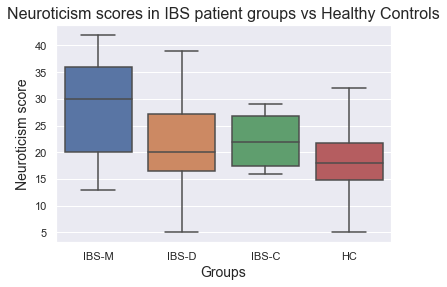

In [133]:
#visualise data
boxplot = sns.boxplot(x='Diagnosis', y='N', data=df_NEOPI_Pain_Rome)
boxplot.axes.set_title("Neuroticism scores in IBS patient groups vs Healthy Controls", fontsize=16)
boxplot.set_xlabel("Groups", fontsize=14)
boxplot.set_ylabel("Neuroticism score", fontsize=14)

<AxesSubplot:xlabel='Diagnosis', ylabel='N'>

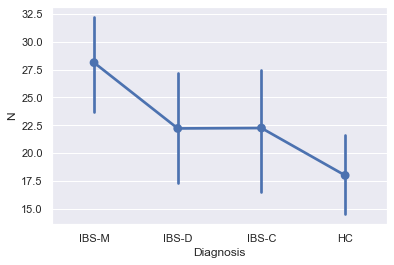

In [134]:
sns.pointplot(x='Diagnosis', y='N', data=df_NEOPI_Pain_Rome)

In [135]:
#run Tukey’s HSD to find out which specific groups’s means (compared with each other) are different.
#The test compares all possible pairs of means.

from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukeyN = pairwise_tukeyhsd(endog=df_NEOPI_Pain_Rome['N'],
                          groups=df_NEOPI_Pain_Rome['Diagnosis'],
                          alpha=0.05)

#display results
print(tukeyN)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    HC  IBS-C     4.25 0.7873  -8.4504 16.9504  False
    HC  IBS-D   4.2143 0.5221  -3.9732 12.4017  False
    HC  IBS-M  10.1176  0.006   2.3472 17.8881   True
 IBS-C  IBS-D  -0.0357    0.9 -13.0619 12.9904  False
 IBS-C  IBS-M   5.8676 0.6033  -6.9005 18.6358  False
 IBS-D  IBS-M   5.9034 0.2442  -2.3888 14.1955  False
-----------------------------------------------------


Results: There is a statistical difference between means of HC and IBS-M groups.

In [136]:
# One-Way Anova Extraversion scores between groups 
aov = pg.anova(dv='E', between='Diagnosis', data=df_NEOPI_Pain_Rome, detailed=True)
print(aov)

      Source           SS  DF         MS         F     p-unc       np2
0  Diagnosis   110.745583   3  36.915194  0.817445  0.490468  0.047662
1     Within  2212.801587  49  45.159216       NaN       NaN       NaN


Interpretation: The test statistic is the F value of 0.817445. Using an α of 0.05, we have F0.05;3,49 = 2.79 (obtained from F distribution table). Since the test statistic is smaller than the critical value, we conclude that there is a no (statistically) significant difference among the population means.

In [138]:
# One-Way Anova Openness scores between groups 
aov = pg.anova(dv='O', between='Diagnosis', data=df_NEOPI_Pain_Rome, detailed=True)
print(aov)

      Source           SS  DF         MS         F     p-unc       np2
0  Diagnosis   284.556049   3  94.852016  1.383767  0.258795  0.078103
1     Within  3358.764706  49  68.546218       NaN       NaN       NaN


Interpretation: The test statistic is the F value of 1.383767. Using an α of 0.05, we have F0.05;3,49 = 2.79 (obtained from F distribution table). Since the test statistic is smaller than the critical value, we conclude that there is a no (statistically) significant difference among the population means.

In [139]:
# One-Way Anova Altruism scores between groups 
aov = pg.anova(dv='A', between='Diagnosis', data=df_NEOPI_Pain_Rome, detailed=True)
print(aov)

      Source           SS  DF         MS         F     p-unc       np2
0  Diagnosis    22.721496   3   7.573832  0.196155  0.898518  0.011867
1     Within  1891.957750  49  38.611383       NaN       NaN       NaN


Interpretation: The test statistic is the F value of 0.196155. Using an α of 0.05, we have F0.05;3,49 = 2.79 (obtained from F distribution table). Since the test statistic is smaller than the critical value, we conclude that there is a no (statistically) significant difference among the population means.

In [140]:
# One-Way Anova Conscientiousness scores between groups 
aov = pg.anova(dv='C', between='Diagnosis', data=df_NEOPI_Pain_Rome, detailed=True)
print(aov)

      Source           SS  DF         MS         F     p-unc       np2
0  Diagnosis    87.808753   3  29.269584  0.732486  0.537627  0.042921
1     Within  1958.002568  49  39.959236       NaN       NaN       NaN


Interpretation: The test statistic is the F value of 0.732486. Using an α of 0.05, we have F0.05;3,49 = 2.79 (obtained from F distribution table). Since the test statistic is smaller than the critical value, we conclude that there is a no (statistically) significant difference among the population means.

# 3. Correlations analyses - the relationships between pain and variables - for both IBS and HC

## NEOPI vs pain

Neuroticism as potential predictor variable of pain


(0.0, 448.13810451342533)

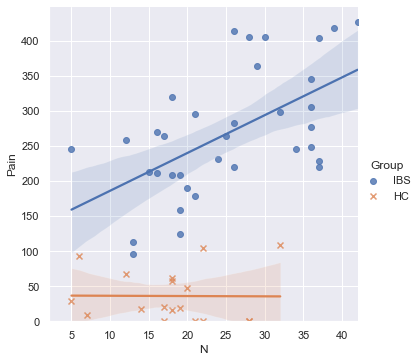

In [141]:
# Neuroticism as potential predictor variable of pain sum_exp / by Group
print("Neuroticism as potential predictor variable of pain")
sns.lmplot(x = "N", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,)

In [142]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

(0.0, 442.4646227506639)

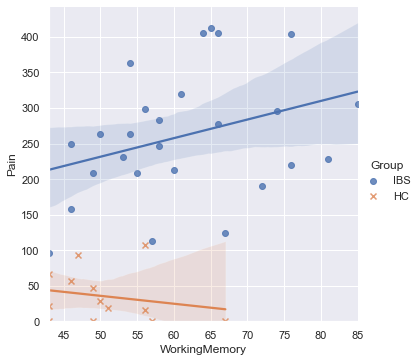

In [143]:
# Working memory as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "WorkingMemory", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,)

(0.0, 497.60454641269547)

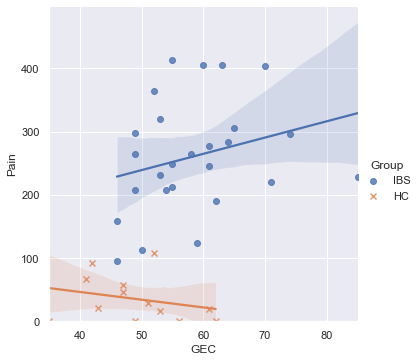

In [144]:
# Working memory as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "GEC", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,)

(0.0, 453.3930090812214)

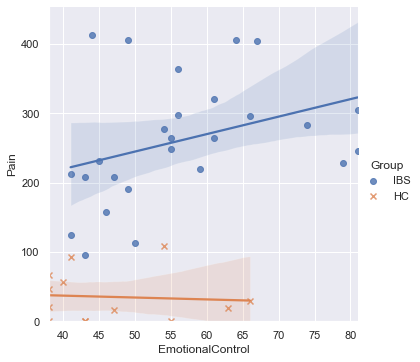

In [145]:
# Initiate score as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "EmotionalControl", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,) 

(0.0, 448.24610810241535)

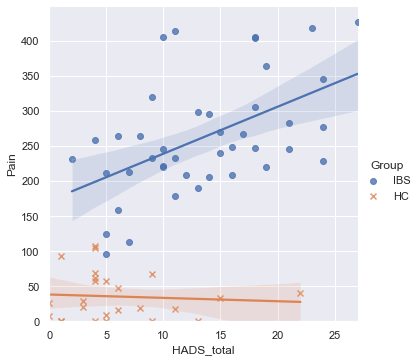

In [146]:
# Initiate score as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "HADS_total", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,) 

(0.0, 447.5865344740285)

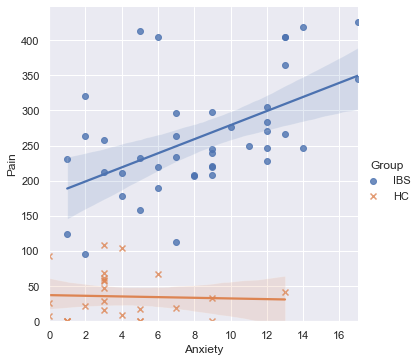

In [147]:
# Initiate score as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "Anxiety", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,) 

(0.0, 457.8979603054824)

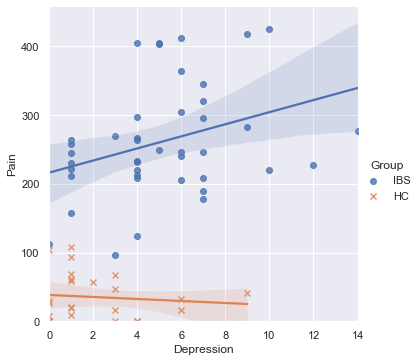

In [148]:
# Initiate score as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "Depression", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,) 

(0.0, 448.74061839321837)

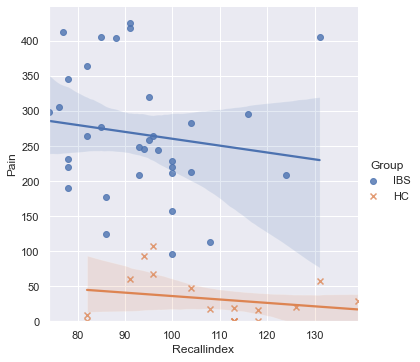

In [149]:
# Total RBANS score as potential predictor variable of pain sum_exp / by Group
sns.lmplot(x = "Recallindex", y = "Pain", data = df, hue='Group', markers=["o", "x"])
plt.ylim(0,) 

(0.0, 482.59335814891176)

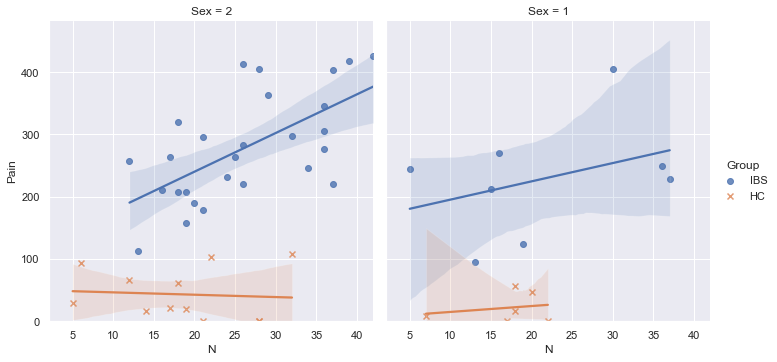

In [150]:
# Sex as potential predictor variable of pain sum_exp. By group and sex.
sns.lmplot(x = "N", y = "Pain", data = df, hue='Group', col='Sex',  markers=["o", "x"])
plt.ylim(0,)
#(1 = M, 2 = F)

## Calculating Pearson Correlation Coefficient and P-value of Age and Pain


In [285]:
df.columns
df_vars_pain = df[['Pain','Education', 'Age', 'Group','N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex', 'Verbalskillsindex',
                   'Attentionindex', 'Recallindex', 'Sumindex']]

In [153]:
df_vars_pain = df_vars_pain.dropna(subset=['Pain','Education', 'Age','N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex', 'Group'])

,Pain,Education,Age,N,E,O,A,C,Inhibit,Shift,EmotionalControl,SelfMonitor,Initiate,WorkingMemory,PlanOrganize,TaskMonitor,Org.ofMaterials,BRI,MI,GEC,HADS_total,Anxiety,Depression,Memory_1_index,Visuoaspatialindex,Verbalskillsindex,Attentionindex,Recallindex,Sumindex
Pain,1.000000,-0.288380,0.125381,0.489698,-0.273425,-0.266284,0.187105,-0.107175,0.025692,0.394986,0.446888,0.231195,0.396498,0.498901,0.272704,0.169054,0.330402,0.398133,0.423293,0.447833,0.586067,0.525064,0.522510,-0.376145,0.104943,-0.103543,-0.080946,-0.440820,-0.334330
Education,-0.288380,1.000000,0.061816,-0.182073,-0.099308,0.358118,0.226881,0.060804,-0.220413,-0.143148,-0.051736,-0.142314,0.021576,-0.264740,-0.083825,-0.168346,-0.268721,-0.153084,-0.185493,-0.185944,-0.251761,-0.268412,-0.170670,0.369281,0.249316,0.045012,0.133466,0.256616,0.357573
Age,0.125381,0.061816,1.000000,-0.247951,0.162729,0.157605,0.103367,0.032199,0.073875,0.062810,0.284741,0.226711,0.175592,0.172937,0.341360,0.215281,0.226946,0.240316,0.280606,0.283865,0.124839,0.003713,0.247014,-0.155953,-0.010530,0.116637,-0.015386,0.097254,0.016213
N,0.489698,-0.182073,-0.247951,1.000000,-0.492931,-0.022424,-0.235880,-0.352938,0.291727,0.724722,0.502025,0.168064,0.463135,0.563071,0.401920,0.270381,0.237972,0.569610,0.487764,0.567055,0.708835,0.718580,0.527132,-0.123052,0.264587,-0.032029,-0.372144,-0.344832,-0.208799
E,-0.273425,-0.099308,0.162729,-0.492931,1.000000,0.064760,0.057220,0.310971,-0.086671,-0.528059,-0.176483,-0.047430,-0.543504,-0.484110,-0.482417,-0.145167,-0.187165,-0.265708,-0.473783,-0.420966,-0.368911,-0.255738,-0.422751,-0.035231,-0.001752,0.483733,0.323695,0.097022,0.279138
O,-0.266284,0.358118,0.157605,-0.022424,0.064760,1.000000,-0.045450,0.075156,0.287409,-0.189824,-0.141729,0.166000,0.061237,-0.007254,0.061129,-0.138543,0.094746,-0.010955,0.043510,0.014671,-0.044858,-0.046371,-0.032233,0.001336,0.044183,0.139697,0.006119,0.172493,0.132087
A,0.187105,0.226881,0.103367,-0.235880,0.057220,-0.045450,1.000000,0.186716,-0.392473,-0.271603,-0.219932,-0.228531,-0.021836,-0.205522,-0.149845,-0.140766,0.008805,-0.339959,-0.127704,-0.239804,-0.243890,-0.254187,-0.172655,-0.046313,0.131805,0.017176,0.264518,-0.078389,0.066275
C,-0.107175,0.060804,0.032199,-0.352938,0.310971,0.075156,0.186716,1.000000,-0.089417,-0.254769,0.097697,-0.026916,-0.463995,-0.318474,-0.328370,-0.242149,-0.263453,-0.046488,-0.405482,-0.269666,-0.266826,-0.169298,-0.325437,-0.086964,-0.001803,0.081462,0.278149,0.044108,0.086349
Inhibit,0.025692,-0.220413,0.073875,0.291727,-0.086671,0.287409,-0.392473,-0.089417,1.000000,0.450434,0.303118,0.695783,0.319341,0.553297,0.568051,0.467731,0.472589,0.681940,0.590685,0.685068,0.353915,0.352737,0.270776,-0.149486,-0.087885,-0.093856,-0.059879,-0.040702,-0.144219
Shift,0.394986,-0.143148,0.062810,0.724722,-0.528059,-0.189824,-0.271603,-0.254769,0.450434,1.000000,0.643159,0.364440,0.545325,0.663206,0.696904,0.580369,0.307238,0.796877,0.684149,0.799379,0.677964,0.604112,0.608563,0.109846,0.132221,-0.066975,-0.299840,-0.135485,-0.075874


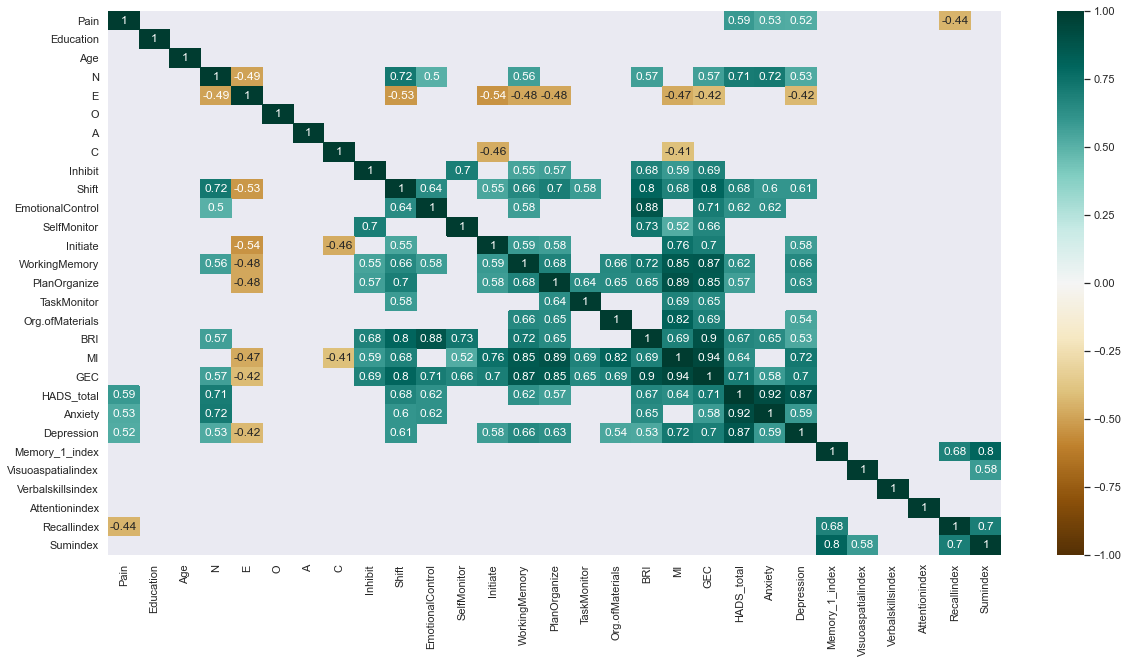

In [154]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df_vars_pain.corr()
sns.heatmap(c[(c >= 0.5) | (c <= -0.4)],cmap='BrBG', annot=True, vmax=1.0, vmin=-1.0, annot_kws={"size": 12})
c

In [155]:
df_vars_pain['Group'].value_counts()

IBS    25
HC     12
Name: Group, dtype: int64

In [156]:
df.count()

ClientID              87
Diagnosis             87
Group                 87
Sex                   65
Education             60
Age                   81
Pain                  67
N                     65
E                     65
O                     65
A                     65
C                     65
Inhibit               43
Shift                 43
EmotionalControl      43
SelfMonitor           43
Initiate              43
WorkingMemory         43
PlanOrganize          43
TaskMonitor           43
Org.ofMaterials       43
BRI                   43
MI                    43
GEC                   43
HADS_total            67
Anxiety               67
Depression            67
Memory_1_index        61
Visuoaspatialindex    61
Verbalskillsindex     61
Attentionindex        61
Recallindex           61
Sumindex              61
dtype: int64

In [157]:
#pearson corr for Age, Education, Pain
df_vars_age = df[['Pain','Education', 'Age']]
df_vars_age.head()
df_vars_age = df_vars_pain.dropna(subset=['Pain','Education', 'Age'])
df_vars_age['Group'].value_counts()

IBS    25
HC     12
Name: Group, dtype: int64

In [158]:
variables = ['Education', 'Age']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_age[v], 
        df_vars_age["Pain"])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")


 Only coefficients with pvalue > 0.05 are displayed


In [159]:
#pearson corr for HADS
df_vars_hads = df[['Pain','HADS_total','Anxiety', 'Depression', 'Group']]
df_vars_hads = df_vars_hads.dropna(subset=['Pain','HADS_total'])
df_vars_hads['Group'].value_counts()

IBS    42
HC     25
Name: Group, dtype: int64

In [160]:
variables = ['HADS_total','Anxiety', 'Depression']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_hads[v], 
        df_vars_hads["Pain"])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient  HADS_total  vs Pain is 0.6345688790870994  with a P-value of P = 8.109072327659285e-09
The Pearson Correlation Coefficient  Anxiety  vs Pain is 0.6127498863927692  with a P-value of P = 3.5643735949193223e-08
The Pearson Correlation Coefficient  Depression  vs Pain is 0.5247239315410014  with a P-value of P = 5.160130282768691e-06

 Only coefficients with pvalue > 0.05 are displayed


In [161]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

In [162]:
#pearson corr for rbans
df_vars_rbans = df[['Pain','Memory_1_index', 'Visuoaspatialindex','Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex', 'Group']]
df_vars_rbans = df_vars_rbans.dropna(subset=['Memory_1_index', 'Pain', 'Group'])
df_vars_rbans['Group'].value_counts()

IBS    34
HC     17
Name: Group, dtype: int64

In [163]:
variables = ['Memory_1_index', 'Visuoaspatialindex','Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_rbans[v], 
        df_vars_rbans["Pain"])
    if p_value < 0.008:
        print("The Pearson Correlation Coefficient with Bonferroni correction ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient with Bonferroni correction  Recallindex  vs Pain is -0.44254337184245457  with a P-value of P = 0.001147057501728697

 Only coefficients with pvalue > 0.05 are displayed


In [164]:
#pearson corr for briefa
df_vars_briefa = df[['Pain', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'Group']]
df_vars_briefa = df_vars_briefa.dropna(subset=['Pain', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'Group'])
df_vars_briefa['Group'].value_counts()

IBS    26
HC     13
Name: Group, dtype: int64

In [165]:
variables = ['Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_briefa[v], 
        df_vars_briefa["Pain"])
    if p_value < 0.004:
        print("The Pearson Correlation Coefficient with Bonferroni ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient with Bonferroni  EmotionalControl  vs Pain is 0.4641502781720579  with a P-value of P = 0.002916238991632112
The Pearson Correlation Coefficient with Bonferroni  WorkingMemory  vs Pain is 0.511825183900542  with a P-value of P = 0.0008668846880744413
The Pearson Correlation Coefficient with Bonferroni  GEC  vs Pain is 0.46501170195514085  with a P-value of P = 0.0028572930104602094

 Only coefficients with pvalue > 0.05 are displayed


In [166]:
#pearson corr for neopi
df_vars_neopi = df[['Pain', 'N', 'E', 'O', 'A', 'C', 'Group']]
df_vars_neopi = df_vars_neopi.dropna(subset=['Pain', 'N', 'E', 'O', 'A', 'C', 'Group'])
df_vars_neopi['Group'].value_counts()

IBS    35
HC     18
Name: Group, dtype: int64

In [ ]:
variables = ['N', 'E', 'O', 'A', 'C']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_neopi[v], 
        df_vars_neopi["Pain"])
    if p_value < 0.01:
        print("The Pearson Correlation Coefficient with Bonferroni ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

Interpretation NEOPI dimensions vs Pain scores
N vs Pain: since the p-value is < 0.001, the correlation between neuroticism and pain score is statistically significant, although the linear relationship isn't extremely strong (~0.549789) (Moderate positive correlation)
E vs Pain: since the p-value is ≤ 0.05, the correlation between extraversion and pain score is statistically significant. The correlation is weak.
No statistical significance for O, A, C dimensions.

In [167]:
#pearson corr for neopi and brief
df_vars_neopi_brief = df[['Pain', 'N', 'E', 'O', 'A', 'C', 'Group', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC' ]]
df_vars_neopi_brief = df_vars_neopi_brief.dropna(subset=['Pain', 'N', 'E', 'O', 'A', 'C', 'Group', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC'])
df_vars_neopi_brief['Group'].value_counts()


IBS    26
HC     13
Name: Group, dtype: int64

In [168]:
# calculate for each item in BRIEF vs NEOPI items

for b in brief:
    for d in dimensions:
        pearson_coef, p_value = stats.pearsonr(
            df_vars_neopi_brief[b], 
            df_vars_neopi_brief[d])
        if p_value < 0.001:
             print("The PCC ", b, " vs", d, "is", pearson_coef, " with a P-value of P =", p_value) 
print("\nOnly correlations where p_value < 0.001 are displayed. ")


The PCC  Shift  vs N is 0.7345716537305492  with a P-value of P = 1.0183532494162729e-07
The PCC  Shift  vs E is -0.5236411616060515  with a P-value of P = 0.0006240205305265796
The PCC  EmotionalControl  vs N is 0.5081191200645152  with a P-value of P = 0.0009587103532405211
The PCC  Initiate  vs E is -0.527175146473112  with a P-value of P = 0.0005642676330659235
The PCC  WorkingMemory  vs N is 0.5608740806606092  with a P-value of P = 0.00020397377764051145
The PCC  BRI  vs N is 0.5641517097905505  with a P-value of P = 0.00018366826740010066
The PCC  MI  vs N is 0.5089723373676889  with a P-value of P = 0.0009368377268375575
The PCC  GEC  vs N is 0.5776146555198514  with a P-value of P = 0.00011799653283821871

Only correlations where p_value < 0.001 are displayed. 


# Correlations - separate for groups

In [169]:
#creating dataframe with IBS patients only
df_vars_pain_ibs = df[df["Group"] == 'IBS']
#creating dataframe with HC patients only
df_vars_pain_hc = df[df["Group"] == 'HC']

In [170]:
df_vars_pain_ibs = df_vars_pain_ibs[['Pain', 'Age','Group','N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']]
df_vars_pain_hc = df_vars_pain_hc[['Pain','Age','Group','N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']]

df_vars_pain_ibs['Group'].value_counts()

IBS    53
Name: Group, dtype: int64

In [171]:
df_vars_pain_hc['Group'].value_counts()

HC    34
Name: Group, dtype: int64

,Pain,Age,N,E,O,A,C,Inhibit,Shift,EmotionalControl,SelfMonitor,Initiate,WorkingMemory,PlanOrganize,TaskMonitor,Org.ofMaterials,BRI,MI,GEC,HADS_total,Anxiety,Depression,Memory_1_index,Visuoaspatialindex,Verbalskillsindex,Attentionindex,Recallindex,Sumindex
Pain,1.000000,-0.218341,0.571617,-0.336479,-0.023688,-0.192632,-0.094097,0.051632,0.325926,0.347620,-0.027260,0.105511,0.326874,0.188737,-0.044415,0.162392,0.285140,0.208449,0.267831,0.518785,0.525147,0.334179,-0.232299,-0.108366,-0.059540,-0.062497,-0.146314,-0.212721
Age,-0.218341,1.000000,-0.492116,0.221924,0.142694,0.187972,0.088604,-0.206641,-0.064922,0.050709,-0.138954,0.017085,0.092598,0.208907,-0.039939,0.191095,-0.070117,0.145350,0.049918,-0.155991,-0.212283,-0.022488,-0.084353,-0.008895,0.112930,-0.172711,0.101914,-0.003770
N,0.571617,-0.492116,1.000000,-0.500581,-0.198798,-0.223760,-0.202405,0.151690,0.729660,0.606556,-0.048634,0.180386,0.487820,0.314610,0.281945,0.031734,0.538867,0.322709,0.487057,0.782736,0.690136,0.661813,-0.163730,-0.082429,-0.130785,-0.264982,-0.284694,-0.292572
E,-0.336479,0.221924,-0.500581,1.000000,0.114816,0.120523,0.344523,0.029367,-0.509454,-0.211643,0.058579,-0.547695,-0.460341,-0.555629,-0.252858,-0.171235,-0.224518,-0.516213,-0.448384,-0.428326,-0.308053,-0.457876,-0.010119,0.158194,0.380686,0.322292,0.032179,0.272979
O,-0.023688,0.142694,-0.198798,0.114816,1.000000,-0.145549,0.121515,0.135296,-0.144070,-0.070134,0.124615,0.083485,0.003078,0.104346,-0.000294,0.223287,-0.004411,0.135461,0.080604,0.044851,0.067944,-0.001135,0.115743,-0.125535,0.155101,-0.021160,0.207064,0.122454
A,-0.192632,0.187972,-0.223760,0.120523,-0.145549,1.000000,0.134988,-0.450348,-0.371615,-0.343352,-0.426003,-0.275894,-0.329233,-0.310854,-0.300847,-0.129970,-0.500862,-0.345059,-0.484363,-0.532410,-0.545616,-0.345376,0.081355,0.133596,0.055399,0.022946,0.038233,0.106628
C,-0.094097,0.088604,-0.202405,0.344523,0.121515,0.134988,1.000000,-0.227842,-0.265570,0.106438,-0.176637,-0.552131,-0.263477,-0.358255,-0.196465,-0.153601,-0.126699,-0.394096,-0.318607,-0.179123,-0.030371,-0.326881,-0.141622,-0.067722,0.075006,-0.037659,-0.077459,-0.079154
Inhibit,0.051632,-0.206641,0.151690,0.029367,0.135296,-0.450348,-0.227842,1.000000,0.427403,0.332628,0.828048,0.326173,0.450792,0.348673,0.326078,0.292233,0.746918,0.446326,0.679384,0.303194,0.311059,0.192642,0.009842,-0.116500,-0.084873,0.031506,0.263972,0.045196
Shift,0.325926,-0.064922,0.729660,-0.509454,-0.144070,-0.371615,-0.265570,0.427403,1.000000,0.623004,0.262648,0.494132,0.576932,0.653911,0.532161,0.192284,0.769059,0.617707,0.800162,0.692276,0.549697,0.642704,0.252943,0.024338,-0.035346,-0.357412,0.028540,0.002450
EmotionalControl,0.347620,0.050709,0.606556,-0.211643,-0.070134,-0.343352,0.106438,0.332628,0.623004,1.000000,0.331490,0.125083,0.494347,0.227857,-0.006203,0.073949,0.843805,0.245230,0.600900,0.621752,0.592608,0.452249,-0.096302,-0.013530,0.096523,-0.327094,-0.054194,-0.108139


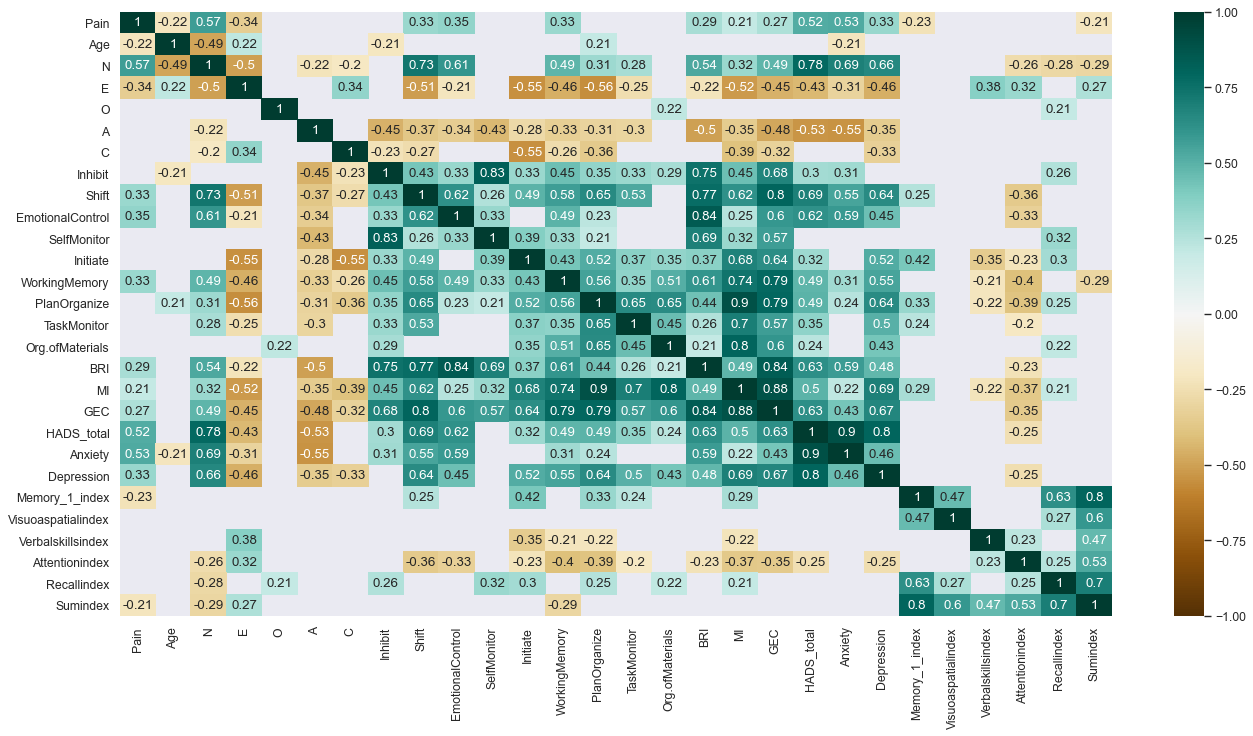

In [172]:
# Correlation matrix IBS.
plt.figure(figsize=(20, 10), dpi=80)
c= df_vars_pain_ibs.corr()
sns.heatmap(c[(c >= 0.2) | (c <= -0.2)],cmap='BrBG', annot=True, vmax=1.0, vmin=-1.0, annot_kws={"size": 12})
c

,Pain,Age,N,E,O,A,C,Inhibit,Shift,EmotionalControl,SelfMonitor,Initiate,WorkingMemory,PlanOrganize,TaskMonitor,Org.ofMaterials,BRI,MI,GEC,HADS_total,Anxiety,Depression,Memory_1_index,Visuoaspatialindex,Verbalskillsindex,Attentionindex,Recallindex,Sumindex
Pain,1.000000,-0.165120,-0.008100,-0.030780,-0.476900,0.308034,0.325421,-0.408747,-0.090102,-0.073618,-0.260596,-0.134276,-0.211876,-0.307798,-0.049040,-0.387925,-0.241706,-0.293066,-0.263740,-0.072197,-0.043688,-0.100124,0.141311,-0.152573,0.062641,0.020353,-0.232251,-0.072827
Age,-0.165120,1.000000,-0.149980,0.306104,-0.151870,-0.042584,0.289299,0.285037,0.335786,0.700096,0.698251,0.071802,0.306617,0.451689,0.693203,-0.118033,0.680086,0.302989,0.500609,-0.334244,-0.287586,-0.348756,-0.206168,-0.024923,0.379055,-0.285961,-0.023878,-0.093431
N,-0.008100,-0.149980,1.000000,-0.533901,0.226263,-0.035572,-0.147382,0.278755,0.609755,0.056592,0.052242,0.567590,0.515943,0.329807,-0.018650,0.123866,0.289160,0.408651,0.371153,0.244223,0.329924,0.037182,-0.051136,0.054216,0.236621,-0.263968,-0.021822,-0.046897
E,-0.030780,0.306104,-0.533901,1.000000,-0.048059,-0.256914,0.040794,-0.074754,-0.472732,0.261135,0.374844,-0.174223,-0.331942,-0.135189,0.259040,-0.035689,0.057942,-0.132771,-0.052269,-0.274246,-0.178286,-0.290843,0.158444,0.096722,0.097690,-0.009860,0.148680,0.178403
O,-0.476900,-0.151870,0.226263,-0.048059,1.000000,-0.089134,-0.255651,0.601759,-0.082399,-0.259252,0.358312,0.495775,0.104678,0.371765,0.041410,0.530326,0.111098,0.452507,0.295201,0.332934,0.177773,0.403197,-0.219040,0.372807,0.163418,0.198260,-0.122345,0.135467
A,0.308034,-0.042584,-0.035572,-0.256914,-0.089134,1.000000,-0.042973,-0.332806,-0.204661,-0.029696,0.100633,0.155483,-0.193980,0.086384,-0.086107,-0.105385,-0.154998,-0.023662,-0.090882,-0.133652,-0.277739,0.105609,0.057449,-0.012484,-0.127255,-0.091881,0.141385,-0.008064
C,0.325421,0.289299,-0.147382,0.040794,-0.255651,-0.042973,1.000000,-0.112415,-0.169011,0.048727,-0.142048,-0.503551,-0.246984,-0.157318,-0.174916,-0.519896,-0.077207,-0.424572,-0.275746,-0.198105,-0.214148,-0.099466,0.074693,0.201925,-0.141726,0.376924,0.029232,0.224759
Inhibit,-0.408747,0.285037,0.278755,-0.074754,0.601759,-0.332806,-0.112415,1.000000,0.352949,0.234589,0.447646,0.479226,0.698189,0.796523,0.468545,0.701538,0.633744,0.822626,0.776857,0.766394,0.636320,0.722304,-0.354001,0.107152,0.096113,0.272265,-0.286515,-0.026059
Shift,-0.090102,0.335786,0.609755,-0.472732,-0.082399,-0.204661,-0.169011,0.352949,1.000000,0.582134,0.321562,0.385736,0.671396,0.507445,0.576417,0.037977,0.737132,0.515896,0.660589,0.377150,0.492613,0.055072,-0.238035,-0.133016,0.447496,-0.223665,-0.171382,-0.129483
EmotionalControl,-0.073618,0.700096,0.056592,0.261135,-0.259252,-0.029696,0.048727,0.234589,0.582134,1.000000,0.642298,0.314309,0.526862,0.557867,0.662030,-0.017650,0.872980,0.475682,0.698497,0.216090,0.408896,-0.180418,0.180661,0.134380,0.346764,-0.112905,0.288127,0.273025


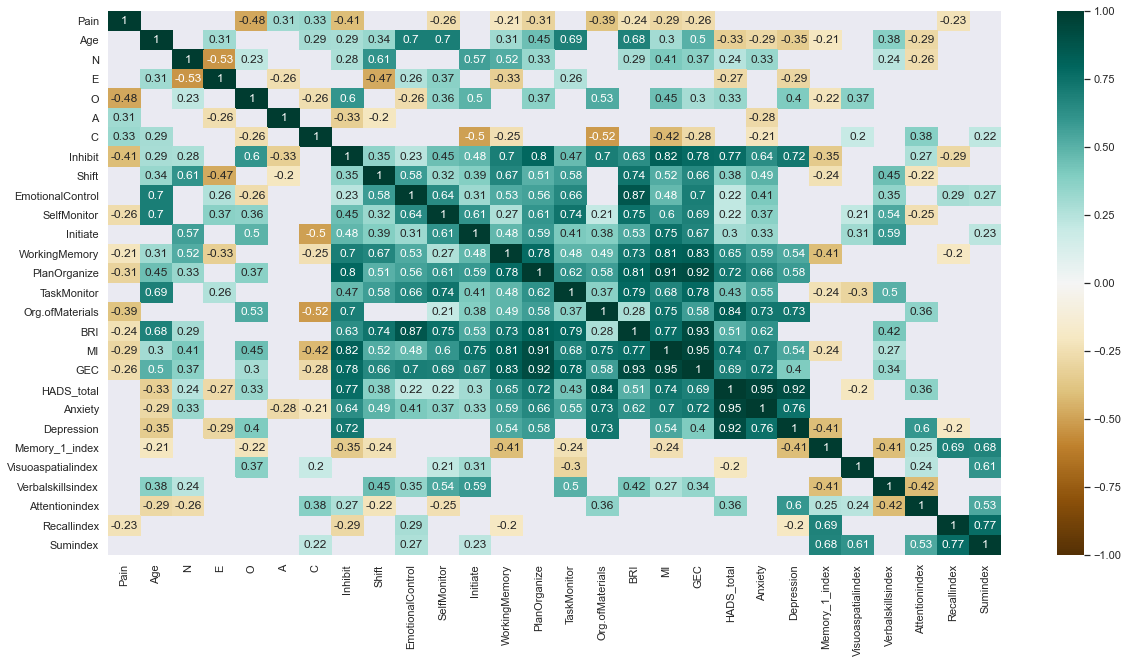

In [173]:
# Correlation matrix HC.
plt.figure(figsize=(20,10))
c= df_vars_pain_hc.corr()
sns.heatmap(c[(c >= 0.2) | (c <= -0.2)],cmap='BrBG', annot=True, vmax=1.0, vmin=-1.0, annot_kws={"size": 12})
c

### Correlations by group
#### Pearson corr for HADS


In [174]:
#IBS only
df_vars_hads_ibs = df[df["Group"] == 'IBS']
df_vars_hads_ibs = df_vars_hads_ibs[['Pain','HADS_total','Anxiety', 'Depression', 'Group']]
df_vars_hads_ibs = df_vars_hads_ibs.dropna(subset=['Pain','HADS_total'])
df_vars_hads_ibs['Group'].value_counts()

IBS    42
Name: Group, dtype: int64

In [175]:
df_vars_hads_ibs.describe()

,Pain,HADS_total,Anxiety,Depression
count,42.000000,42.000000,42.000000,42.000000
mean,261.880952,13.452381,8.285714,5.166667
std,82.217499,6.371439,4.307032,3.122824
min,96.000000,2.000000,1.000000,0.000000
25%,214.750000,9.000000,5.000000,4.000000
50%,246.500000,13.000000,8.500000,5.000000
75%,297.500000,18.000000,12.000000,7.000000
max,426.000000,27.000000,17.000000,14.000000


In [176]:
variables = ['HADS_total','Anxiety', 'Depression', 'Pain']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_hads_ibs[v], 
        df_vars_hads_ibs['Pain'])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient in the IBS group ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient in the IBS group  HADS_total  vs Pain is 0.5187853411881932  with a P-value of P = 0.000431742535468978
The Pearson Correlation Coefficient in the IBS group  Anxiety  vs Pain is 0.5251472615682922  with a P-value of P = 0.00035593211137814926
The Pearson Correlation Coefficient in the IBS group  Depression  vs Pain is 0.3341793187747273  with a P-value of P = 0.030542574113487524
The Pearson Correlation Coefficient in the IBS group  Pain  vs Pain is 1.0  with a P-value of P = 0.0

 Only coefficients with pvalue > 0.05 are displayed


In [177]:
variables = ['HADS_total','Anxiety', 'Depression', 'Pain']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_hads_ibs[v], 
        df_vars_hads_ibs['Depression'])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient in the IBS group ", v, " vs Depression is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient in the IBS group  HADS_total  vs Depression is 0.7990382912892173  with a P-value of P = 2.254362340951256e-10
The Pearson Correlation Coefficient in the IBS group  Anxiety  vs Depression is 0.4569735238155823  with a P-value of P = 0.002348096703550868
The Pearson Correlation Coefficient in the IBS group  Depression  vs Depression is 1.0  with a P-value of P = 0.0
The Pearson Correlation Coefficient in the IBS group  Pain  vs Depression is 0.3341793187747273  with a P-value of P = 0.030542574113487524

 Only coefficients with pvalue > 0.05 are displayed


#### Pearson corr for RBANS

In [178]:
#pearson corr for rbans IBS only
df_vars_rbans_ibs = df[df["Group"] == 'IBS']
df_vars_rbans_ibs = df_vars_rbans_ibs[['Pain','Memory_1_index', 'Visuoaspatialindex','Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex', 'Group']]
df_vars_rbans_ibs = df_vars_rbans_ibs.dropna(subset=['Memory_1_index', 'Pain'])
df_vars_rbans_ibs['Group'].value_counts()

IBS    34
Name: Group, dtype: int64

In [179]:
variables = ['Memory_1_index', 'Visuoaspatialindex','Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_rbans_ibs[v], 
        df_vars_rbans_ibs["Pain"])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient for RBANS measure", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue < 0.05 are displayed")


 Only coefficients with pvalue < 0.05 are displayed


#### Pearson corr for BRIEFA

In [180]:
#pearson corr for rbans IBS only
df_vars_briefa_ibs = df[df["Group"] == 'IBS']
df_vars_briefa_ibs = df_vars_briefa_ibs[['Pain', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'Group']]
df_vars_briefa_ibs = df_vars_briefa_ibs.dropna(subset=['Pain', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'Group'])
df_vars_briefa_ibs['Group'].value_counts()

IBS    26
Name: Group, dtype: int64

In [181]:
variables = ['Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_briefa_ibs[v], 
        df_vars_briefa_ibs["Pain"])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")


 Only coefficients with pvalue > 0.05 are displayed


#### Pearson corr for NEOPI

In [182]:
#pearson corr for neopi IBS group only
df_vars_neopi_ibs = df[df["Group"] == 'IBS']
df_vars_neopi_ibs = df_vars_neopi_ibs[['Pain', 'N', 'E', 'O', 'A', 'C', 'Group']]
df_vars_neopi_ibs = df_vars_neopi_ibs.dropna(subset=['Pain', 'N', 'E', 'O', 'A', 'C', 'Group'])
df_vars_neopi_ibs['Group'].value_counts()

IBS    35
Name: Group, dtype: int64

In [183]:
variables = ['N', 'E', 'O', 'A', 'C']
for v in variables:
    pearson_coef, p_value = stats.pearsonr(
        df_vars_neopi_ibs[v], 
        df_vars_neopi_ibs["Pain"])
    if p_value < 0.05:
        print("The Pearson Correlation Coefficient with Bonferroni ", v, " vs Pain is", pearson_coef, " with a P-value of P =", p_value) 
print("\n Only coefficients with pvalue > 0.05 are displayed")

The Pearson Correlation Coefficient with Bonferroni  N  vs Pain is 0.5716170950919122  with a P-value of P = 0.0003345896570271826
The Pearson Correlation Coefficient with Bonferroni  E  vs Pain is -0.3364794147159655  with a P-value of P = 0.04810966889780385

 Only coefficients with pvalue > 0.05 are displayed


# Logistic regression IBS/HC group vs other variables - Machine Learning model

In [217]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

In [286]:
df_regression = df[['Group', 'Age',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials']]


In [219]:
df_regression = df_regression.dropna(subset=['Group', 'Age',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials'])
df_regression.count()

Group               42
Age                 42
N                   42
E                   42
O                   42
A                   42
C                   42
Inhibit             42
Shift               42
EmotionalControl    42
SelfMonitor         42
Initiate            42
WorkingMemory       42
PlanOrganize        42
TaskMonitor         42
Org.ofMaterials     42
dtype: int64

In [287]:
#Data normalization (Feature scaling) -  standardize the range of features of data.
feature_cols = ['Age','N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials']

from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

for  f in feature_cols:
    df_regression[f] = std_scale.fit_transform(df_regression[[f]])


In [288]:
#hot encode Group. Make  it Binary. FOR 
df_regression=pd.concat([df_regression,pd.get_dummies(df_regression['Group'],prefix='Group')],axis=1).drop(['Group'],axis=1)
df_regression.drop(columns='Group_HC', inplace = True)
df_regression.rename(columns={'Group_IBS': 'Group'}, inplace = True)
# IBS = 1
df_regression['Group'] = df_regression['Group'].astype(int) 


In [289]:
#split df_regression dataset in features and target variable

X = df_regression[feature_cols] # Features
y = df_regression['Group']# Target variable

In [290]:
# Splitting Data

#To evaluate model performance -=  divide the dataset into a training set and a test set.
# Let's split dataset by using function train_test_split(). 
# Here, the Dataset is broken into two parts in a ratio of 75:25. 
# 75% data will be used for model training and 25% for model testing.

# split X and y into training and testing sets
#!pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (65, 15) (65,)
Test set: (22, 15) (22,)


In [224]:
#Model Development and Prediction


from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters). Choosing the "liblinear" algorithm (our data set is small)
#Regularization is a technique used to solve the overfitting problem in machine learning models. 
#C parameter indicates inverse of regularization strength which must be a positive float.
#Smaller values specify stronger regularization. 
# fit the model with data

LR = LogisticRegression(C=0.01, solver='liblinear', max_iter=200).fit(X_train,y_train)
LR

LogisticRegression(C=0.01, max_iter=200, solver='liblinear')

In [226]:
# perform prediction on the test set 
yhat = LR.predict(X_test)
yhat

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [227]:
#predict_proba returns estimates for all classes, ordered by the label of classes. 
#So, the first column is the probability of class 1, P(Y=1|X), 
# and second column is probability of class 0, P(Y=0|X):
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.60427363, 0.39572637],
       [0.49643076, 0.50356924],
       [0.50785378, 0.49214622],
       [0.45164899, 0.54835101],
       [0.4790581 , 0.5209419 ],
       [0.44294589, 0.55705411],
       [0.5288768 , 0.4711232 ],
       [0.49069823, 0.50930177],
       [0.45481123, 0.54518877],
       [0.49928289, 0.50071711],
       [0.3773558 , 0.6226442 ]])

## Evaluation

### jaccard index
Lets try jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by the size of the union of two label sets. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.




In [228]:
from sklearn import metrics
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)

0.6666666666666666

In [229]:
#Model Evaluation using Confusion Matrix
# import the metrics class

cnf_matrix = metrics.confusion_matrix(y_test, yhat)
cnf_matrix

array([[2, 2],
       [1, 6]])

In [230]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[6 1]
 [2 2]]


Confusion matrix, without normalization
[[6 1]
 [2 2]]


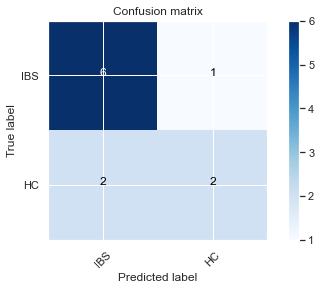

In [231]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['IBS','HC'],normalize= False,  title='Confusion matrix')

 Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. 

The first row is for participants who belong to the IBS group. Out of 11 participants, 7 are from the IBS group. And out of these 7, the classifier correctly predicted 6 of them as IBS, and 1 of them as HC.

It means, for 6 participants, the actual value of Group was "1", meaning they had IBS diagnosis  in test set, and classifier also correctly predicted those as IBS patients. However, while the actual label of 1 participant was IBS, the classifier predicted him/her as HC. We can consider it as error of the model for first row.

What about the HC participants? It looks like there were 4 HC participants. 

The classifier correctly predicted 2 of them as HC, and 2 of them wrongly as IBS. So, it seems that the classifier is better at predicting IBS rather than HC.

In [232]:
from sklearn.metrics import classification_report
print("Accuracy:",metrics.accuracy_score(y_test, yhat))
#print("Precision:",metrics.precision_score(y_test, yhat))
#print("Recall:",metrics.recall_score(y_test, yhat))
print (classification_report(y_test, yhat))

Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.75      0.86      0.80         7

    accuracy                           0.73        11
   macro avg       0.71      0.68      0.69        11
weighted avg       0.72      0.73      0.72        11



Classification rate of 72%, considered as good accuracy.

Precision: shows how often the model is correct when it makes a prediction.  In our prediction case, when the Logistic Regression model predicted patients are going to get IBS diagnosis, that happened for 67% of patients.
Recall: Shows if there are patients who have IBS in the test set and your Logistic Regression model can identify it 100% of the time.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The weighted average F1-Score is 0.64, which is not bad given the very low n.


In [233]:
# Log loss( Logarithmic loss) measures the performance of a classifier where 
# the predicted output is a probability value between 0 and 1.
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6411550623867477

# Linear regression PAIN  vs other variables - Machine Learning model

In [237]:
df.columns

Index(['ClientID', 'Diagnosis', 'Group', 'Sex', 'Education', 'Age', 'Pain',
       'N', 'E', 'O', 'A', 'C', 'Inhibit', 'Shift', 'EmotionalControl',
       'SelfMonitor', 'Initiate', 'WorkingMemory', 'PlanOrganize',
       'TaskMonitor', 'Org.ofMaterials', 'BRI', 'MI', 'GEC', 'HADS_total',
       'Anxiety', 'Depression', 'Memory_1_index', 'Visuoaspatialindex',
       'Verbalskillsindex', 'Attentionindex', 'Recallindex', 'Sumindex'],
      dtype='object')

In [244]:
df_pain_ml = df[['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex']]
df_pain_ml.head()
df_pain_ml.count()

Pain                67
N                   65
EmotionalControl    43
WorkingMemory       43
HADS_total          67
Recallindex         61
dtype: int64

In [245]:
df_pain_ml = df_pain_ml.dropna(subset=['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex'])
df_pain_ml.count()

Pain                39
N                   39
EmotionalControl    39
WorkingMemory       39
HADS_total          39
Recallindex         39
dtype: int64

In [291]:
#Data normalization (Feature scaling) -  standardize the range of features of data.
features = ['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex']

from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

for  f in features:
    df_pain_ml[f] = std_scale.fit_transform(df_pain_ml[[f]])

df_pain_ml['Pain'] = std_scale.fit_transform(df_pain_ml[['Pain']])


In [247]:
#### Creating train and test dataset
msk = np.random.rand(len(df_pain_ml)) < 0.8
train = df_pain_ml[msk]
test = df_pain_ml[~msk]

In [249]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex']])
y = np.asanyarray(train[['Pain']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 1.00e+00  1.03e-16  1.51e-16  1.93e-16  3.83e-16 -1.51e-16]]


In [250]:
y_hat= regr.predict(test[['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex']])
x = np.asanyarray(test[['Pain',
       'N',  'EmotionalControl',
        'WorkingMemory', 'HADS_total', 'Recallindex']])
y = np.asanyarray(test[['Pain']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 0.00
Variance score: 1.00


Residual sum of squares is shows that the model has a good performance (a value of zero shows perfect fit of the model). At first, I used all variables - this resulted in rather unsatisfactory perfomance. When I select only statiscitally significant variables (with Bonferroni correction), this performance of the model is very good. 
